In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
import xgboost as xgb


def instantiate_XGBoost_model (X_train, y_train):
    param_grid = {
        "max_depth": [3, 5, 7],
        #"learning_rate": [0.1, 0.2],
        "gamma": [0.25, 1],
        #"reg_lambda": [0, 1, 10],
        "scale_pos_weight": [1, 3, 5],
        #"subsample": [0.8],
        "colsample_bytree": [0.5, 0.9] }

    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
import xgboost as xgb

def create_final_cl(X_over, y_over, X_test, y_test, colsample_bytree, gamma, max_depth, scale_pos_weight):

    result_accuracy = []
    result_f1 = []
    result_precision = []
    result_recall = []
    result_roc_auc = []

    # parametrizando o modelo final
    final_cl = xgb.XGBClassifier(colsample_bytree = colsample_bytree, gamma = gamma, max_depth = max_depth, scale_pos_weight = scale_pos_weight)
    
    #treinando o modelo final
    final_cl.fit(X_over, y_over)

    preds = final_cl.predict(X_test)

    accuracy_score(y_test, preds)
    
    print('"""Accuracy"""')
    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)
    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('macro: ', f1_score(y_test, preds, average='macro'))
    print('micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('macro: ', precision_score(y_test, preds, average='macro'))
    print('micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas recall_score:"""')
    print('Recall: ', recall_score(y_test, preds))
    print('macro: ', recall_score(y_test, preds, average='macro'))
    print('micro: ', recall_score(y_test, preds, average='micro'))
    print('weighted: ', recall_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""ROC_AUC Score:"""')
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    result_accuracy.append(accuracy_score(y_test, preds))

    result_f1.append(f1_score(y_test, preds))
    result_f1.append(f1_score(y_test, preds, average='macro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))

    result_precision.append(precision_score(y_test, preds))
    result_precision.append(precision_score(y_test, preds, average='macro'))
    result_precision.append(precision_score(y_test, preds, average='micro'))
    result_precision.append(precision_score(y_test, preds, average='weighted'))

    result_recall.append(precision_score(y_test, preds))
    result_recall.append(precision_score(y_test, preds, average='macro'))
    result_recall.append(precision_score(y_test, preds, average='micro'))
    result_recall.append(precision_score(y_test, preds, average='weighted'))

    result_roc_auc.append(roc_auc_score(y_test, preds, multi_class='ovr'))

    return preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc
 

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl):
    # plot feature importance
    plt.figure(figsize=(14,14))
    plot_importance(final_cl)
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):

    results_accuracy = []
    results_f1 = []
    results_precision = []
    results_recall = []
    results_roc_auc = []

    if d == 90:
        for i in range (0,758,30):
        
            #treino!
            data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
            data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
            data_fim = data_inicio + pd.Timedelta(days = d)
            
            treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
            X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
            y_train = treino['death']

            #teste!
            teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
            X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
            y_test = teste['death']

            oversample = RandomOverSampler(sampling_strategy='minority')
            X_over, y_over = oversample.fit_resample(X_train, y_train)

            print('Início do período: ', data_inicio)
            print('Final do período: ', data_fim)

            ####################################################
            #              APLICANDO O MODELO                  #
            ####################################################

            list_random_states = [42]
            #list_random_states = [0,12,42,50,54,68,79,81,92,112]

            mean_test_scores = []
            std_test_scores = []
            best_scores = []
            best_params = []

            for random_state in list_random_states:

                mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

                mean_test_scores.append(mean_test_score)
                std_test_scores.append(std_test_score)
                best_scores.append(best_score)
                best_params.append(best_param)

            idx = best_scores.index(max(best_scores))
            best_param = best_params[idx]
            #preds, final_cl  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])

            preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])
            
            results_accuracy.append(result_accuracy)
            results_f1.append(result_f1)
            results_precision.append(result_precision)
            results_recall.append(result_recall)
            results_roc_auc.append(result_roc_auc)

            plot_conf_matrix (X_test, y_test, preds, final_cl)

            plot_roc_curve(y_test, preds)

            plot_feature_importance(final_cl)

        return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

    if d==120:

            for i in range (0,728,30):
    
                #treino!
                data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
                data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
                data_fim = data_inicio + pd.Timedelta(days = d)
        
                treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
                X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
                y_train = treino['death']

                #teste!
                teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]
                X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
                y_test = teste['death']

                oversample = RandomOverSampler(sampling_strategy='minority')
                X_over, y_over = oversample.fit_resample(X_train, y_train)

                print('Início do período: ', data_inicio)
                print('Final do período: ', data_fim)

                ####################################################
                #              APLICANDO O MODELO                  #
                ####################################################

                list_random_states = [42]
                #list_random_states = [0,12,42,50,54,68,79,81,92,112]

                mean_test_scores = []
                std_test_scores = []
                best_scores = []
                best_params = []

                for random_state in list_random_states:

                    mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

                    mean_test_scores.append(mean_test_score)
                    std_test_scores.append(std_test_score)
                    best_scores.append(best_score)
                    best_params.append(best_param)

                idx = best_scores.index(max(best_scores))
                best_param = best_params[idx]

                preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc  = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])

                results_accuracy.append(result_accuracy)
                results_f1.append(result_f1)
                results_precision.append(result_precision)
                results_recall.append(result_recall)
                results_roc_auc.append(result_roc_auc)

                plot_conf_matrix (X_test, y_test, preds, final_cl)

                plot_roc_curve(y_test, preds)

                plot_feature_importance(final_cl)

            return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_22396\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


SYMPTOM_COUGH  SYMPTOM_COLD  SYMPTOM_AIR_INSUFFICIENCY  SYMPTOM_FEVER  \
0                  0             0                          0              1   
1                  0             0                          0              1   
2                  1             0                          1              1   
3                  1             0                          1              1   
4                  1             0                          1              1   
...              ...           ...                        ...            ...   
36430              1             0                          1              1   
36431              1             0                          1              0   
36432              1             0                          1              0   
36433              1             0                          1              0   
36434              1             0                          1              0   

       SYMPTOM_LOW_OXYGEN_SATURATION  SYMPTOM_BREATHING_CONDITION  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
36430                              0                            0   
36431                              0                            0   
36432                              0                            0   
36433                              0                            0   
36434                              0                            0   

       SYMPTOM_TORACIC_APERTURE  SYMPTOM_THROAT_CONDITION  SYMPTOM_HEADACHE  \
0                             0                         1                 0   
1                             0                         1                 0   
2                             0                         1                 0   
3                             0                         1                 1   
4                             0                         0                 1   
...                         ...                       ...               ...   
36430                         0                         0                 0   
36431                         0                         0                 0   
36432                         0                         0                 0   
36433                         0                         0                 0   
36434                         0                         0                 0   

       SYMPTOM_BODY_PAIN  ...  DISEASE_IMMUNOSUPPRESSION  DISEASE_TABAGIST  \
0                      0  ...                          0                 0   
1                      0  ...                          0                 0   
2                      0  ...                          0                 0   
3                      0  ...                          0                 0   
4                      0  ...                          0                 0   
...                  ...  ...                        ...               ...   
36430                  0  ...                          0                 0   
36431                  0  ...                          0                 0   
36432                  0  ...                          0                 0   
36433                  0  ...                          0                 0   
36434                  0  ...                          0                 0   

       DISEASE_ETILISM  DISEASE_LIVER  DISEASE_NEUROLOGIC  death     idade  \
0                    0              0                   0      0  0.356522   
1                    0              0                   0      0  0.278261   
2                    0              0                   0      0  0.217391   
3                  

### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.9560200992831271
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.7480950756283408
########################################
"""Métricas f1_score:"""
f1:  0.5683102709023582
macro:  0.6952350230465223
micro:  0.7480950756283408
weighted:  0.76375677881001
########################################
"""Métricas precision_score:"""
Precision:  0.4691119691119691
macro:  0.6848638121725193
micro:  0.7480950756283408
weighted:  0.801339872562424
########################################
"""Métricas recall_score:"""
Recall:  0.7207118141374197
macro:  0.7384947549269079
micro:  0.7480950756283408
weighted:  0.7480950756283408
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.7384947549269079


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


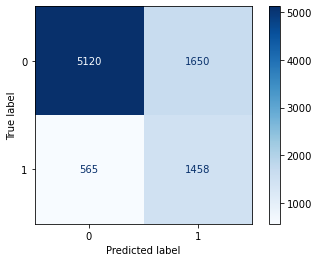

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      6770
           1       0.47      0.72      0.57      2023

    accuracy                           0.75      8793
   macro avg       0.68      0.74      0.70      8793
weighted avg       0.80      0.75      0.76      8793

roc_auc_score:  0.7384947549269079


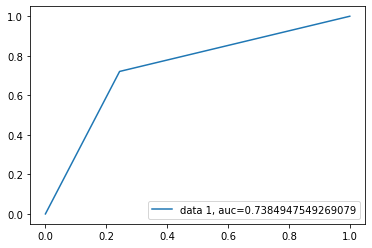

<Figure size 1008x1008 with 0 Axes>

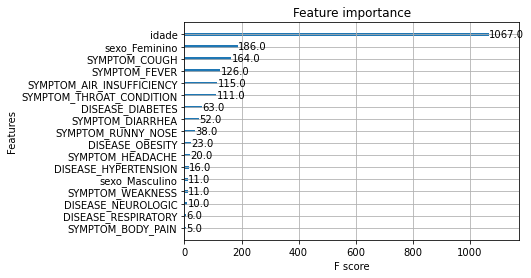

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9357532239303665
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5792519115519735
########################################
"""Métricas f1_score:"""
f1:  0.5280482151135837
macro:  0.5742403640817733
micro:  0.5792519115519735
weighted:  0.5954988711601279
########################################
"""Métricas precision_score:"""
Precision:  0.378656914893617
macro:  0.6437249620890805
micro:  0.5792519115519735
weighted:  0.7657143278886873
########################################
"""Métricas recall_score:"""
Recall:  0.8721286370597243
macro:  0.6715582330501
micro:  0.5792519115519735
weighted:  0.5792519115519735
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6715582330501


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


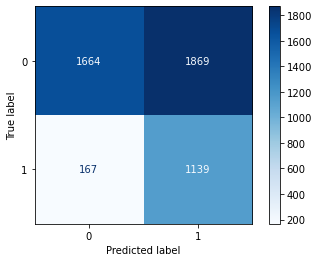

              precision    recall  f1-score   support

           0       0.91      0.47      0.62      3533
           1       0.38      0.87      0.53      1306

    accuracy                           0.58      4839
   macro avg       0.64      0.67      0.57      4839
weighted avg       0.77      0.58      0.60      4839

roc_auc_score:  0.6715582330501


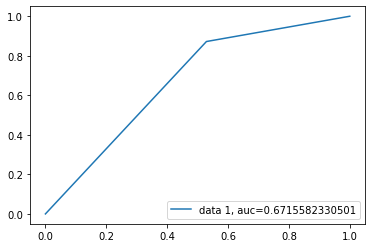

<Figure size 1008x1008 with 0 Axes>

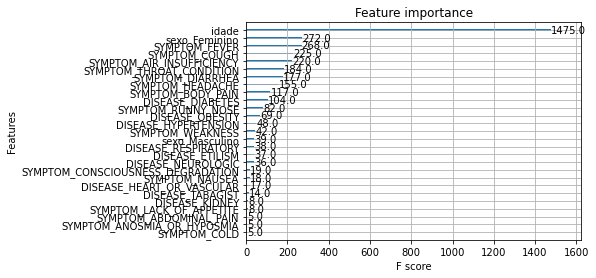

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.8708874371793517
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5672770700636943
########################################
"""Métricas f1_score:"""
f1:  0.46373951652688705
macro:  0.5505217435820955
micro:  0.5672770700636943
weighted:  0.6001313287935921
########################################
"""Métricas precision_score:"""
Precision:  0.31564808596373406
macro:  0.6245884613591886
micro:  0.5672770700636943
weighted:  0.8011960963384372
########################################
"""Métricas recall_score:"""
Recall:  0.8736059479553904
macro:  0.6786976041701978
micro:  0.5672770700636943
weighted:  0.5672770700636943
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6786976041701978


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


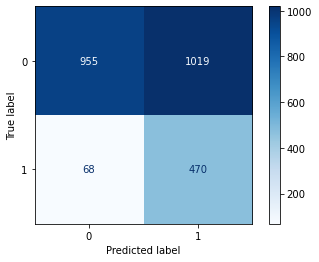

              precision    recall  f1-score   support

           0       0.93      0.48      0.64      1974
           1       0.32      0.87      0.46       538

    accuracy                           0.57      2512
   macro avg       0.62      0.68      0.55      2512
weighted avg       0.80      0.57      0.60      2512

roc_auc_score:  0.6786976041701978


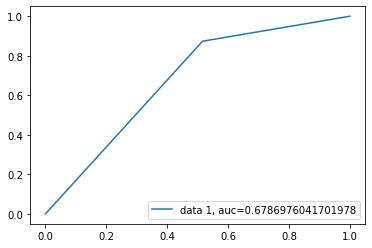

<Figure size 1008x1008 with 0 Axes>

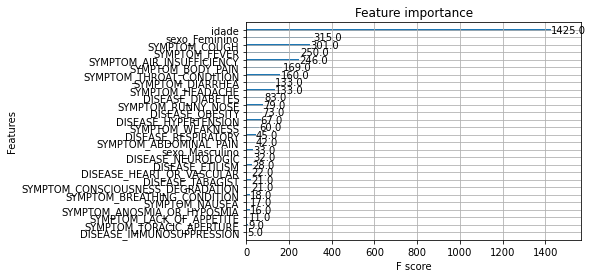

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8684252698786967
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6278742374472079
########################################
"""Métricas f1_score:"""
f1:  0.43235504652827483
macro:  0.5777831079063713
micro:  0.6278742374472079
weighted:  0.6686159327276977
########################################
"""Métricas precision_score:"""
Precision:  0.3029087261785356
macro:  0.6082444865460579
micro:  0.6278742374472079
weighted:  0.7989539642791279
########################################
"""Métricas recall_score:"""
Recall:  0.755
macro:  0.6767489890236857
micro:  0.6278742374472079
weighted:  0.6278742374472079
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6767489890236857


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


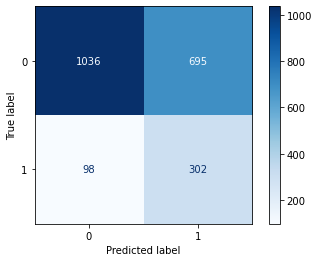

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      1731
           1       0.30      0.76      0.43       400

    accuracy                           0.63      2131
   macro avg       0.61      0.68      0.58      2131
weighted avg       0.80      0.63      0.67      2131

roc_auc_score:  0.6767489890236857


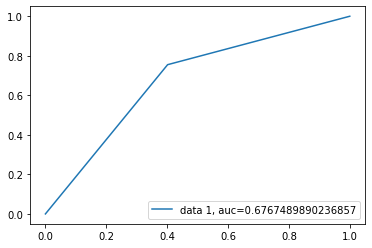

<Figure size 1008x1008 with 0 Axes>

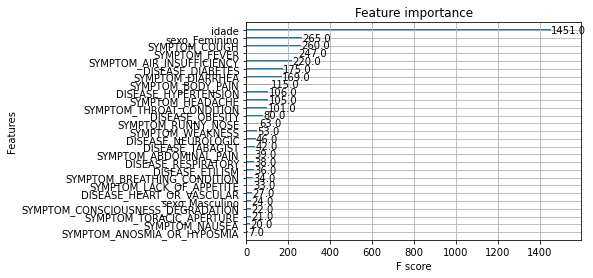

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.9246830347148356
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6531314521679285
########################################
"""Métricas f1_score:"""
f1:  0.4246575342465753
macro:  0.5881908360888048
micro:  0.6531314521679285
weighted:  0.6911729222454739
########################################
"""Métricas precision_score:"""
Precision:  0.30642504118616143
macro:  0.6041581470706221
micro:  0.6531314521679285
weighted:  0.7916500891795563
########################################
"""Métricas recall_score:"""
Recall:  0.6914498141263941
macro:  0.6679377449010349
micro:  0.6531314521679285
weighted:  0.6531314521679285
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6679377449010349


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


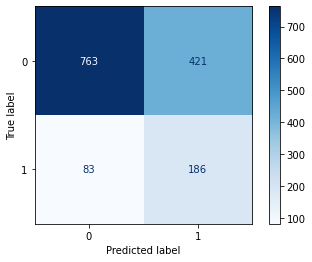

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      1184
           1       0.31      0.69      0.42       269

    accuracy                           0.65      1453
   macro avg       0.60      0.67      0.59      1453
weighted avg       0.79      0.65      0.69      1453

roc_auc_score:  0.6679377449010349


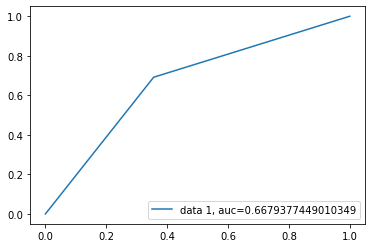

<Figure size 1008x1008 with 0 Axes>

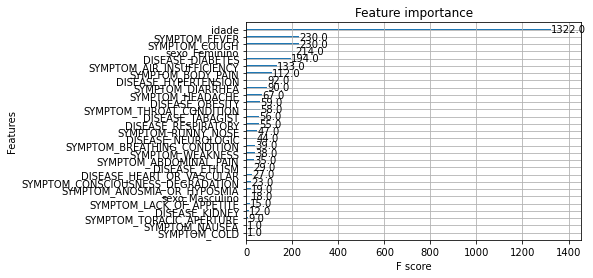

Início do período:  2020-07-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9386032611895654
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.665680473372781
########################################
"""Métricas f1_score:"""
f1:  0.46948356807511743
macro:  0.6127115464565652
micro:  0.665680473372781
weighted:  0.6878567974417035
########################################
"""Métricas precision_score:"""
Precision:  0.3768844221105528
macro:  0.61457857469164
micro:  0.665680473372781
weighted:  0.7392859604639659
########################################
"""Métricas recall_score:"""
Recall:  0.6224066390041494
macro:  0.650789347962618
micro:  0.665680473372781
weighted:  0.665680473372781
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.650789347962618


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


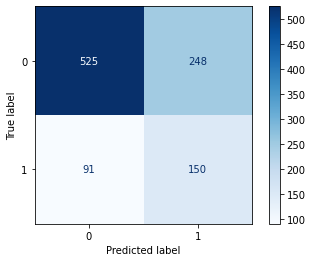

              precision    recall  f1-score   support

           0       0.85      0.68      0.76       773
           1       0.38      0.62      0.47       241

    accuracy                           0.67      1014
   macro avg       0.61      0.65      0.61      1014
weighted avg       0.74      0.67      0.69      1014

roc_auc_score:  0.650789347962618


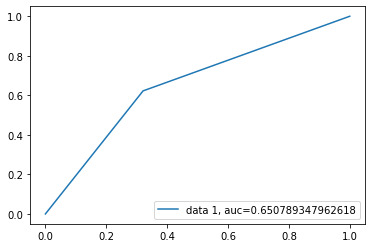

<Figure size 1008x1008 with 0 Axes>

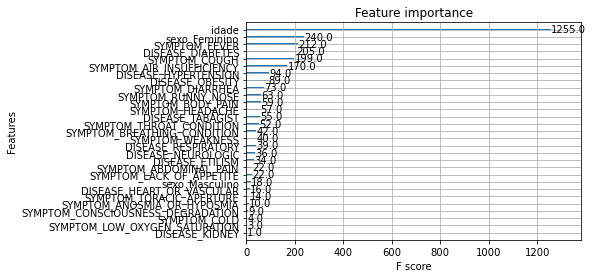

Início do período:  2020-08-24 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9337002335633171
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6633027522935779
########################################
"""Métricas f1_score:"""
f1:  0.4688856729377714
macro:  0.6112057646085768
micro:  0.6633027522935779
weighted:  0.6707451791057211
########################################
"""Métricas precision_score:"""
Precision:  0.43315508021390375
macro:  0.6083373166432647
micro:  0.6633027522935779
weighted:  0.6816245641770157
########################################
"""Métricas recall_score:"""
Recall:  0.5110410094637224
macro:  0.6183924322868418
micro:  0.6633027522935779
weighted:  0.6633027522935779
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6183924322868417


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


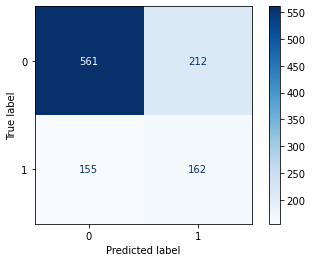

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       773
           1       0.43      0.51      0.47       317

    accuracy                           0.66      1090
   macro avg       0.61      0.62      0.61      1090
weighted avg       0.68      0.66      0.67      1090

roc_auc_score:  0.6183924322868417


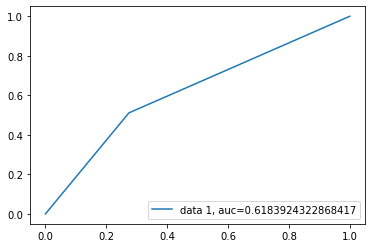

<Figure size 1008x1008 with 0 Axes>

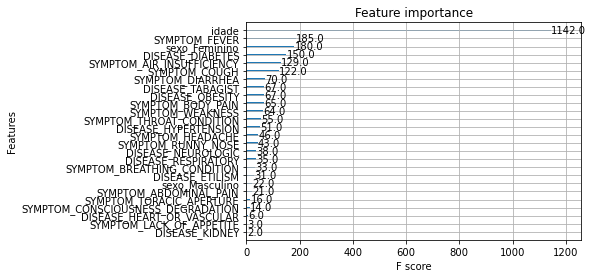

Início do período:  2020-09-23 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9003340155736211
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6421455938697318
########################################
"""Métricas f1_score:"""
f1:  0.5190525231719876
macro:  0.6170613439532909
micro:  0.6421455938697318
weighted:  0.6495807457910721
########################################
"""Métricas precision_score:"""
Precision:  0.47102803738317756
macro:  0.6160334992110693
micro:  0.6421455938697318
weighted:  0.6641464225608602
########################################
"""Métricas recall_score:"""
Recall:  0.5779816513761468
macro:  0.6261599856420434
micro:  0.6421455938697318
weighted:  0.6421455938697318
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6261599856420434


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


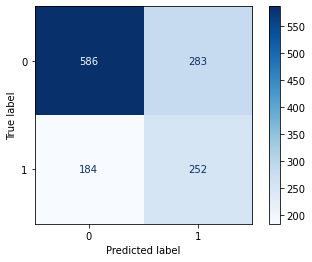

              precision    recall  f1-score   support

           0       0.76      0.67      0.72       869
           1       0.47      0.58      0.52       436

    accuracy                           0.64      1305
   macro avg       0.62      0.63      0.62      1305
weighted avg       0.66      0.64      0.65      1305

roc_auc_score:  0.6261599856420434


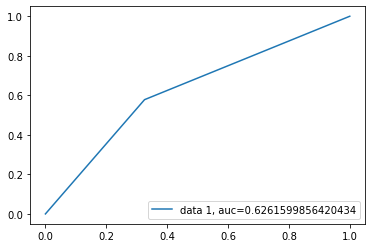

<Figure size 1008x1008 with 0 Axes>

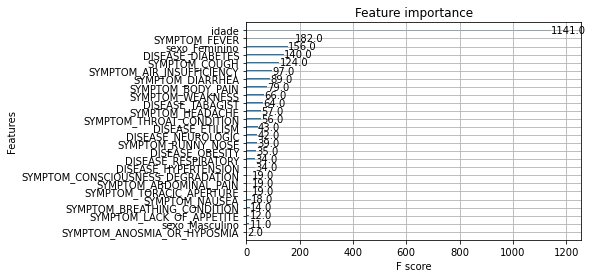

Início do período:  2020-10-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.9093395481960043
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6297814207650273
########################################
"""Métricas f1_score:"""
f1:  0.5600649350649352
macro:  0.620244731683411
micro:  0.6297814207650273
weighted:  0.6389070456620913
########################################
"""Métricas precision_score:"""
Precision:  0.47455295735900965
macro:  0.628728310429844
micro:  0.6297814207650273
weighted:  0.6765395196471655
########################################
"""Métricas recall_score:"""
Recall:  0.6831683168316832
macro:  0.6424183607098979
micro:  0.6297814207650273
weighted:  0.6297814207650273
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.642418360709898


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


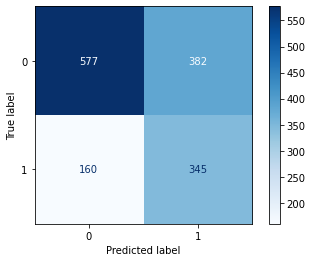

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       959
           1       0.47      0.68      0.56       505

    accuracy                           0.63      1464
   macro avg       0.63      0.64      0.62      1464
weighted avg       0.68      0.63      0.64      1464

roc_auc_score:  0.642418360709898


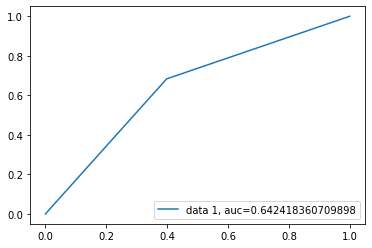

<Figure size 1008x1008 with 0 Axes>

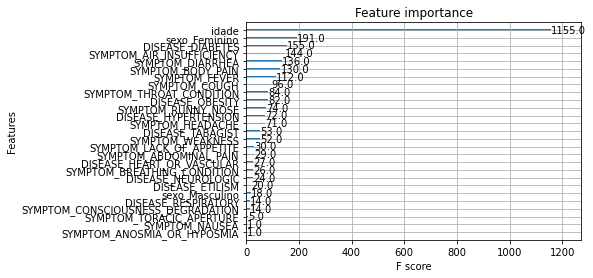

Início do período:  2020-11-22 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8627760589304936
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6450939457202505
########################################
"""Métricas f1_score:"""
f1:  0.5840130505709624
macro:  0.6372735155767434
micro:  0.6450939457202505
weighted:  0.6545081128124345
########################################
"""Métricas precision_score:"""
Precision:  0.4837837837837838
macro:  0.6500697972003567
micro:  0.6450939457202505
weighted:  0.7038784236712728
########################################
"""Métricas recall_score:"""
Recall:  0.7366255144032922
macro:  0.6674715374329816
micro:  0.6450939457202505
weighted:  0.6450939457202505
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6674715374329815


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


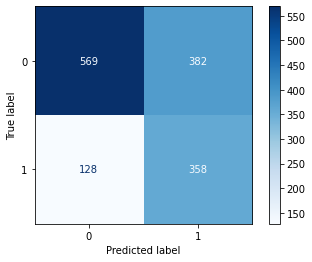

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       951
           1       0.48      0.74      0.58       486

    accuracy                           0.65      1437
   macro avg       0.65      0.67      0.64      1437
weighted avg       0.70      0.65      0.65      1437

roc_auc_score:  0.6674715374329815


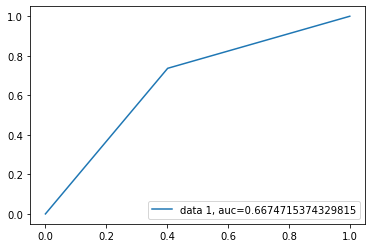

<Figure size 1008x1008 with 0 Axes>

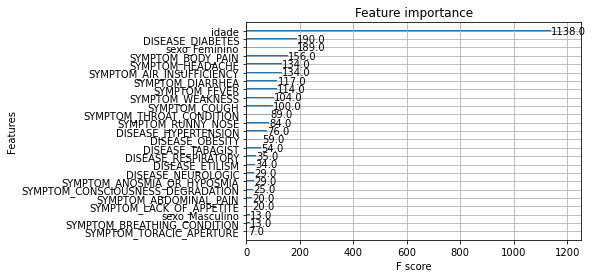

Início do período:  2020-12-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8529954269570611
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.656988188976378
########################################
"""Métricas f1_score:"""
f1:  0.5762917933130699
macro:  0.6440781000463655
micro:  0.656988188976378
weighted:  0.6679634325370346
########################################
"""Métricas precision_score:"""
Precision:  0.48024316109422494
macro:  0.6520833030351507
micro:  0.656988188976378
weighted:  0.7126332743096108
########################################
"""Métricas recall_score:"""
Recall:  0.7203647416413373
macro:  0.6735011481132451
micro:  0.656988188976378
weighted:  0.656988188976378
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6735011481132451


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


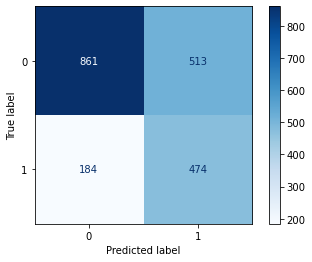

              precision    recall  f1-score   support

           0       0.82      0.63      0.71      1374
           1       0.48      0.72      0.58       658

    accuracy                           0.66      2032
   macro avg       0.65      0.67      0.64      2032
weighted avg       0.71      0.66      0.67      2032

roc_auc_score:  0.6735011481132451


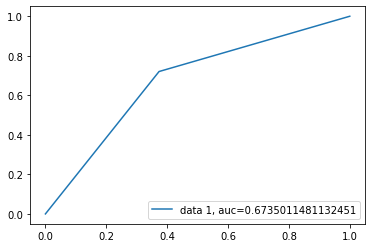

<Figure size 1008x1008 with 0 Axes>

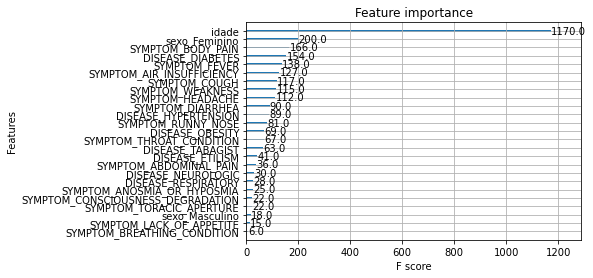

Início do período:  2021-01-21 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8547598107823671
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.656599932134374
########################################
"""Métricas f1_score:"""
f1:  0.5441441441441441
macro:  0.6343475211738685
micro:  0.656599932134374
weighted:  0.6660273634628963
########################################
"""Métricas precision_score:"""
Precision:  0.4778481012658228
macro:  0.6343488872342186
micro:  0.656599932134374
weighted:  0.6893126854959389
########################################
"""Métricas recall_score:"""
Recall:  0.6317991631799164
macro:  0.6501537252363669
micro:  0.656599932134374
weighted:  0.656599932134374
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6501537252363669


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


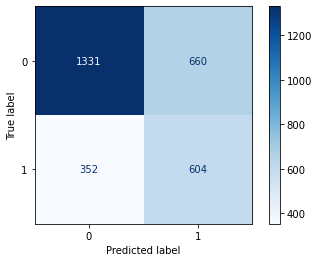

              precision    recall  f1-score   support

           0       0.79      0.67      0.72      1991
           1       0.48      0.63      0.54       956

    accuracy                           0.66      2947
   macro avg       0.63      0.65      0.63      2947
weighted avg       0.69      0.66      0.67      2947

roc_auc_score:  0.6501537252363669


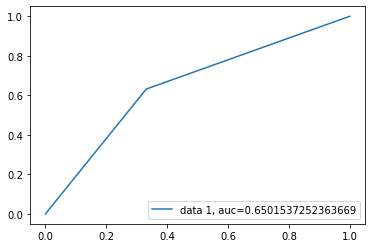

<Figure size 1008x1008 with 0 Axes>

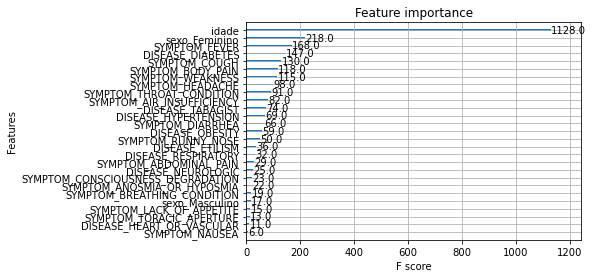

Início do período:  2021-02-20 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8532411049793206
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5839598997493735
########################################
"""Métricas f1_score:"""
f1:  0.5374203821656051
macro:  0.5797056367561922
micro:  0.5839598997493735
weighted:  0.5950421791479806
########################################
"""Métricas precision_score:"""
Precision:  0.4161528976572133
macro:  0.6162745700924837
micro:  0.5839598997493735
weighted:  0.6888571888454119
########################################
"""Métricas recall_score:"""
Recall:  0.7584269662921348
macro:  0.6303958268139602
micro:  0.5839598997493735
weighted:  0.5839598997493735
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6303958268139602


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


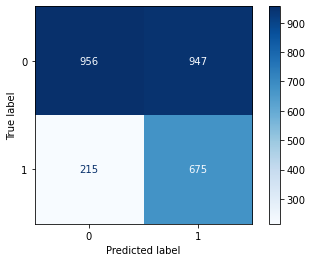

              precision    recall  f1-score   support

           0       0.82      0.50      0.62      1903
           1       0.42      0.76      0.54       890

    accuracy                           0.58      2793
   macro avg       0.62      0.63      0.58      2793
weighted avg       0.69      0.58      0.60      2793

roc_auc_score:  0.6303958268139602


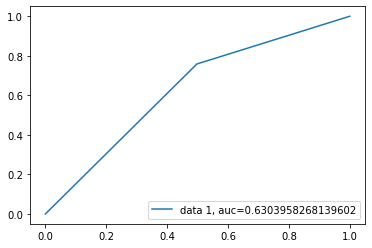

<Figure size 1008x1008 with 0 Axes>

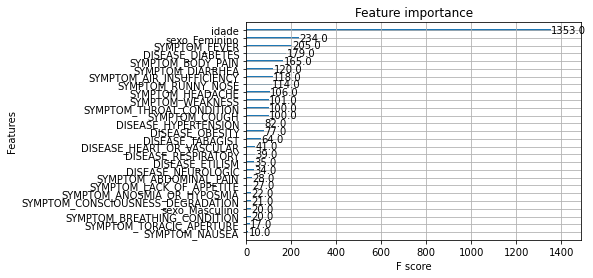

Início do período:  2021-03-22 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.841173370644156
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5550959007145544
########################################
"""Métricas f1_score:"""
f1:  0.5081081081081081
macro:  0.55099878457242
micro:  0.5550959007145544
weighted:  0.5692099819128518
########################################
"""Métricas precision_score:"""
Precision:  0.3725609756097561
macro:  0.6107162091002657
micro:  0.5550959007145544
weighted:  0.7118359001911966
########################################
"""Métricas recall_score:"""
Recall:  0.7986928104575164
macro:  0.6276990979425914
micro:  0.5550959007145544
weighted:  0.5550959007145544
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6276990979425914


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


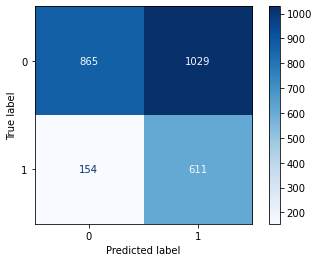

              precision    recall  f1-score   support

           0       0.85      0.46      0.59      1894
           1       0.37      0.80      0.51       765

    accuracy                           0.56      2659
   macro avg       0.61      0.63      0.55      2659
weighted avg       0.71      0.56      0.57      2659

roc_auc_score:  0.6276990979425914


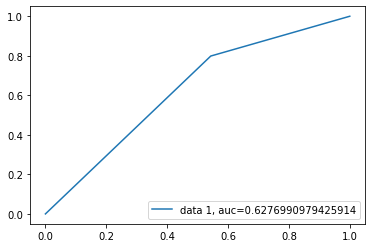

<Figure size 1008x1008 with 0 Axes>

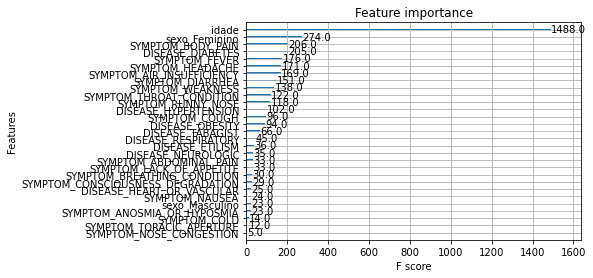

Início do período:  2021-04-21 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8717878650302417
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5816857440166493
########################################
"""Métricas f1_score:"""
f1:  0.508557457212714
macro:  0.5722135112150526
micro:  0.5816857440166493
weighted:  0.5994379005958655
########################################
"""Métricas precision_score:"""
Precision:  0.3830570902394107
macro:  0.6113850044498489
micro:  0.5816857440166493
weighted:  0.709036172754209
########################################
"""Métricas recall_score:"""
Recall:  0.7563636363636363
macro:  0.6340127219719056
micro:  0.5816857440166493
weighted:  0.5816857440166493
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6340127219719056


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


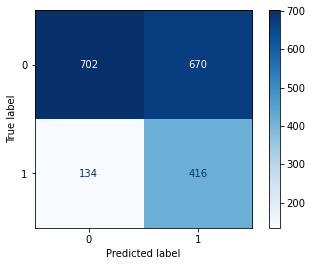

              precision    recall  f1-score   support

           0       0.84      0.51      0.64      1372
           1       0.38      0.76      0.51       550

    accuracy                           0.58      1922
   macro avg       0.61      0.63      0.57      1922
weighted avg       0.71      0.58      0.60      1922

roc_auc_score:  0.6340127219719056


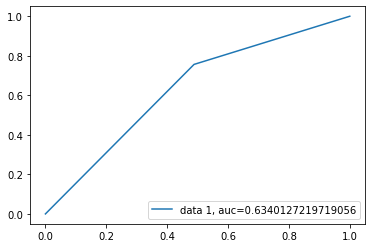

<Figure size 1008x1008 with 0 Axes>

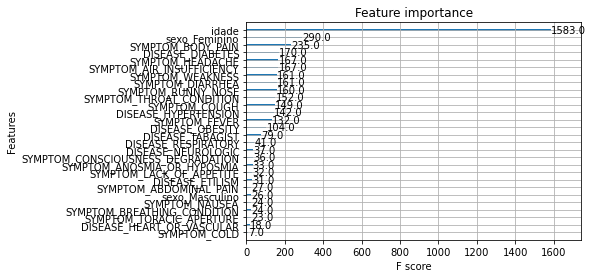

Início do período:  2021-05-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.8815559085992428
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6144366197183099
########################################
"""Métricas f1_score:"""
f1:  0.5663366336633663
macro:  0.6096342439315247
micro:  0.6144366197183099
weighted:  0.6234315457951455
########################################
"""Métricas precision_score:"""
Precision:  0.4590690208667737
macro:  0.63109396462442
micro:  0.6144366197183099
weighted:  0.6859117724063459
########################################
"""Métricas recall_score:"""
Recall:  0.7390180878552972
macro:  0.6445424217647648
micro:  0.6144366197183099
weighted:  0.6144366197183099
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6445424217647647


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


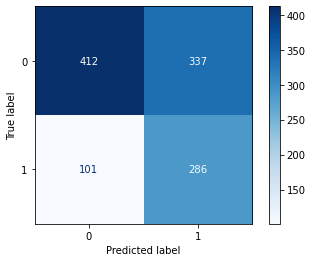

              precision    recall  f1-score   support

           0       0.80      0.55      0.65       749
           1       0.46      0.74      0.57       387

    accuracy                           0.61      1136
   macro avg       0.63      0.64      0.61      1136
weighted avg       0.69      0.61      0.62      1136

roc_auc_score:  0.6445424217647647


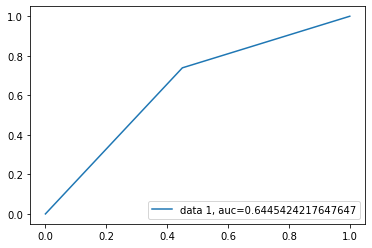

<Figure size 1008x1008 with 0 Axes>

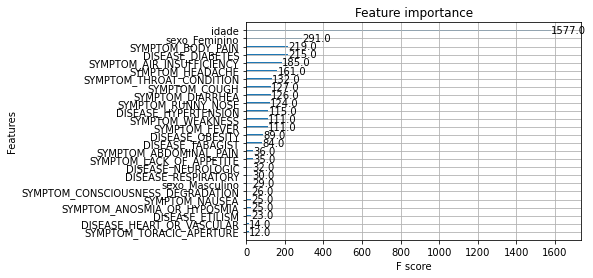

Início do período:  2021-06-20 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8729988941057085
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.585820895522388
########################################
"""Métricas f1_score:"""
f1:  0.5249643366619116
macro:  0.5789099522339326
micro:  0.585820895522388
weighted:  0.6003808440038912
########################################
"""Métricas precision_score:"""
Precision:  0.4008714596949891
macro:  0.6163777588330018
micro:  0.585820895522388
weighted:  0.7021514102312159
########################################
"""Métricas recall_score:"""
Recall:  0.7603305785123967
macro:  0.6355033675480133
micro:  0.585820895522388
weighted:  0.585820895522388
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6355033675480134


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


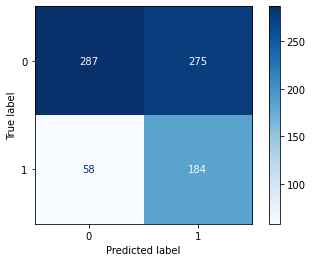

              precision    recall  f1-score   support

           0       0.83      0.51      0.63       562
           1       0.40      0.76      0.52       242

    accuracy                           0.59       804
   macro avg       0.62      0.64      0.58       804
weighted avg       0.70      0.59      0.60       804

roc_auc_score:  0.6355033675480134


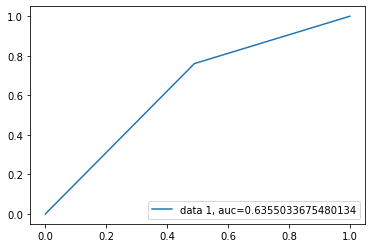

<Figure size 1008x1008 with 0 Axes>

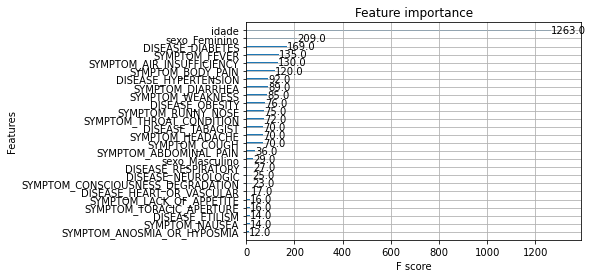

Início do período:  2021-07-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8915174439018163
best_params_: {'colsample_bytree': 0.5, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5691788526434196
########################################
"""Métricas f1_score:"""
f1:  0.49271523178807947
macro:  0.5591630899898364
micro:  0.5691788526434196
weighted:  0.590630523401467
########################################
"""Métricas precision_score:"""
Precision:  0.3570057581573896
macro:  0.613285487774347
micro:  0.5691788526434196
weighted:  0.734650804049644
########################################
"""Métricas recall_score:"""
Recall:  0.7948717948717948
macro:  0.6417107065962028
micro:  0.5691788526434196
weighted:  0.5691788526434196
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6417107065962027


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


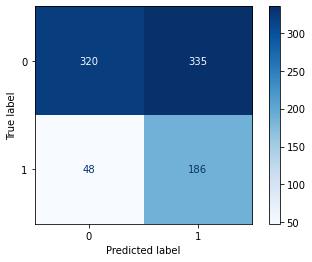

              precision    recall  f1-score   support

           0       0.87      0.49      0.63       655
           1       0.36      0.79      0.49       234

    accuracy                           0.57       889
   macro avg       0.61      0.64      0.56       889
weighted avg       0.73      0.57      0.59       889

roc_auc_score:  0.6417107065962027


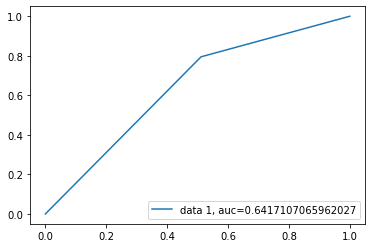

<Figure size 1008x1008 with 0 Axes>

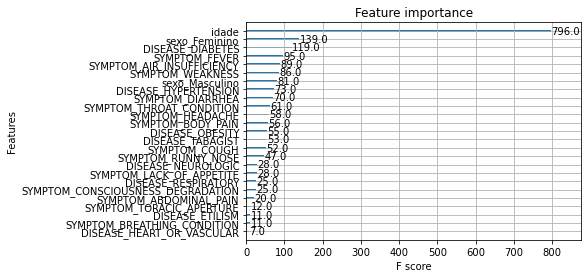

Início do período:  2021-08-19 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.903314208984375
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6048714479025711
########################################
"""Métricas f1_score:"""
f1:  0.3652173913043478
macro:  0.5391902280686769
micro:  0.6048714479025711
weighted:  0.635946433630435
########################################
"""Métricas precision_score:"""
Precision:  0.28378378378378377
macro:  0.5515984381672869
micro:  0.6048714479025711
weighted:  0.7005454245700201
########################################
"""Métricas recall_score:"""
Recall:  0.5121951219512195
macro:  0.5717497348886532
micro:  0.6048714479025711
weighted:  0.6048714479025711
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5717497348886532


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


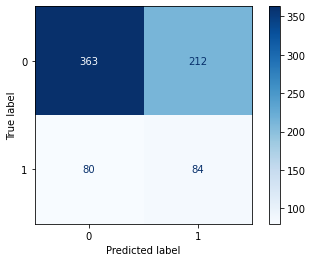

              precision    recall  f1-score   support

           0       0.82      0.63      0.71       575
           1       0.28      0.51      0.37       164

    accuracy                           0.60       739
   macro avg       0.55      0.57      0.54       739
weighted avg       0.70      0.60      0.64       739

roc_auc_score:  0.5717497348886532


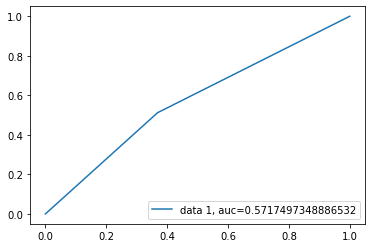

<Figure size 1008x1008 with 0 Axes>

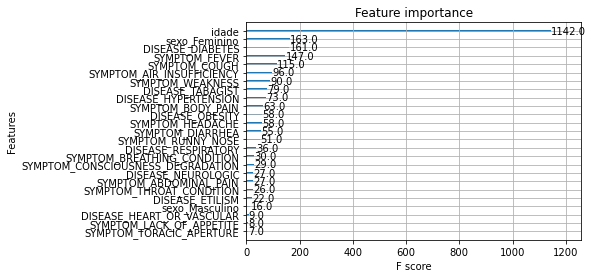

Início do período:  2021-09-18 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9208406036420348
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6101231190150479
########################################
"""Métricas f1_score:"""
f1:  0.3448275862068966
macro:  0.533660141691569
micro:  0.6101231190150479
weighted:  0.6413799442047132
########################################
"""Métricas precision_score:"""
Precision:  0.2697841726618705
macro:  0.5443843600616196
micro:  0.6101231190150479
weighted:  0.7010304313963601
########################################
"""Métricas recall_score:"""
Recall:  0.47770700636942676
macro:  0.5620242348920305
micro:  0.6101231190150479
weighted:  0.6101231190150479
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5620242348920305


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


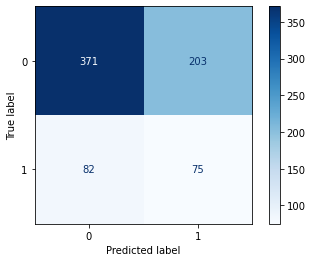

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       574
           1       0.27      0.48      0.34       157

    accuracy                           0.61       731
   macro avg       0.54      0.56      0.53       731
weighted avg       0.70      0.61      0.64       731

roc_auc_score:  0.5620242348920305


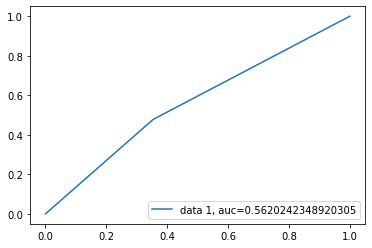

<Figure size 1008x1008 with 0 Axes>

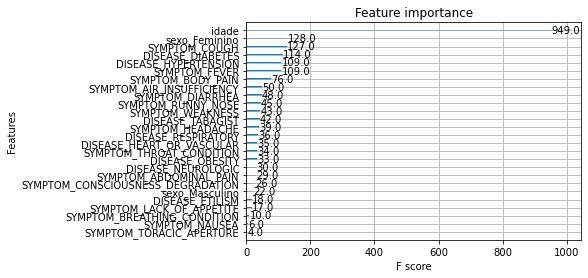

Início do período:  2021-10-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9455701352757544
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6260869565217392
########################################
"""Métricas f1_score:"""
f1:  0.33689205219454327
macro:  0.5382643772849754
micro:  0.6260869565217392
weighted:  0.6464262348419099
########################################
"""Métricas precision_score:"""
Precision:  0.2857142857142857
macro:  0.5406527340395075
micro:  0.6260869565217392
weighted:  0.6775862283573358
########################################
"""Métricas recall_score:"""
Recall:  0.41040462427745666
macro:  0.5507201537401208
micro:  0.6260869565217392
weighted:  0.6260869565217392
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5507201537401208


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


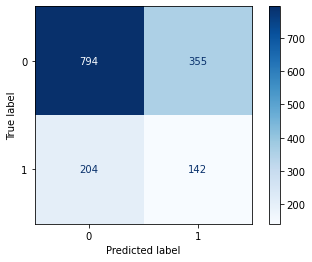

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1149
           1       0.29      0.41      0.34       346

    accuracy                           0.63      1495
   macro avg       0.54      0.55      0.54      1495
weighted avg       0.68      0.63      0.65      1495

roc_auc_score:  0.5507201537401208


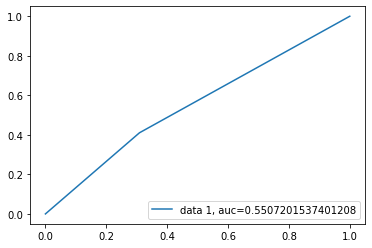

<Figure size 1008x1008 with 0 Axes>

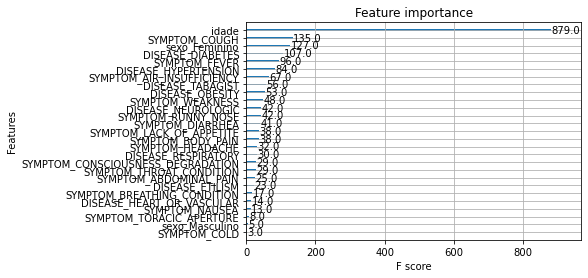

Início do período:  2021-11-17 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9046907546867489
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5654862282181
########################################
"""Métricas f1_score:"""
f1:  0.372055239642567
macro:  0.5199339369678241
micro:  0.5654862282181
weighted:  0.5954942157023146
########################################
"""Métricas precision_score:"""
Precision:  0.2876884422110553
macro:  0.5390629393150902
micro:  0.5654862282181
weighted:  0.6675055575655497
########################################
"""Métricas recall_score:"""
Recall:  0.5264367816091954
macro:  0.5522808908045977
micro:  0.5654862282181
weighted:  0.5654862282181
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5522808908045977


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


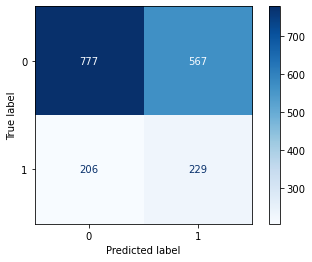

              precision    recall  f1-score   support

           0       0.79      0.58      0.67      1344
           1       0.29      0.53      0.37       435

    accuracy                           0.57      1779
   macro avg       0.54      0.55      0.52      1779
weighted avg       0.67      0.57      0.60      1779

roc_auc_score:  0.5522808908045977


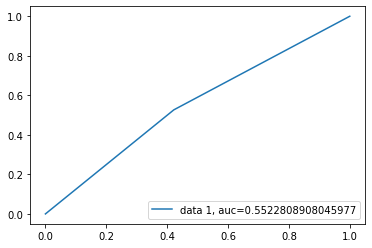

<Figure size 1008x1008 with 0 Axes>

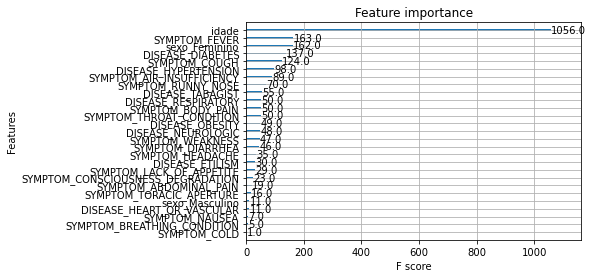

Início do período:  2021-12-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8707856039213597
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.5247813411078717
########################################
"""Métricas f1_score:"""
f1:  0.4171632896305125
macro:  0.5080074036339601
micro:  0.5247813411078717
weighted:  0.5425264012776414
########################################
"""Métricas precision_score:"""
Precision:  0.33653846153846156
macro:  0.5268153997279734
micro:  0.5247813411078717
weighted:  0.5991169379515877
########################################
"""Métricas recall_score:"""
Recall:  0.54858934169279
macro:  0.5313369243675217
micro:  0.5247813411078717
weighted:  0.5247813411078717
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5313369243675217


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


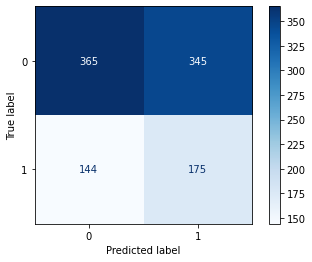

              precision    recall  f1-score   support

           0       0.72      0.51      0.60       710
           1       0.34      0.55      0.42       319

    accuracy                           0.52      1029
   macro avg       0.53      0.53      0.51      1029
weighted avg       0.60      0.52      0.54      1029

roc_auc_score:  0.5313369243675217


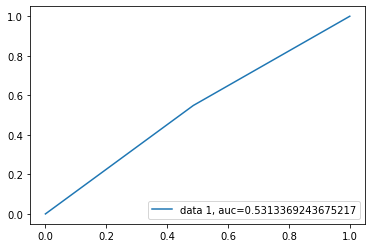

<Figure size 1008x1008 with 0 Axes>

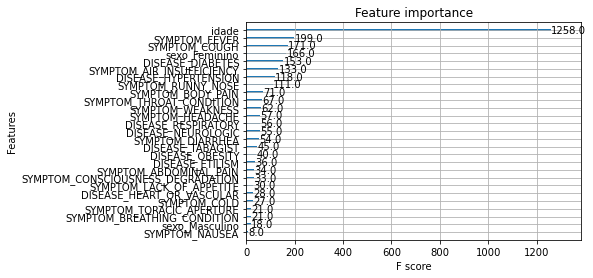

Início do período:  2022-01-16 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8721940212082234
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6432225063938619
########################################
"""Métricas f1_score:"""
f1:  0.5633802816901408
macro:  0.6308793300342596
micro:  0.6432225063938619
weighted:  0.6477972500795885
########################################
"""Métricas precision_score:"""
Precision:  0.5202312138728323
macro:  0.6305284509731135
micro:  0.6432225063938619
weighted:  0.658173282778299
########################################
"""Métricas recall_score:"""
Recall:  0.6143344709897611
macro:  0.6374330841656373
micro:  0.6432225063938619
weighted:  0.6432225063938619
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6374330841656372


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


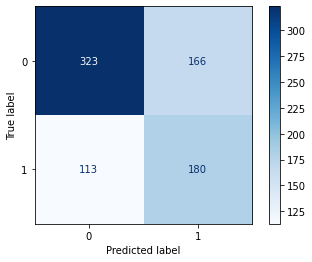

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       489
           1       0.52      0.61      0.56       293

    accuracy                           0.64       782
   macro avg       0.63      0.64      0.63       782
weighted avg       0.66      0.64      0.65       782

roc_auc_score:  0.6374330841656372


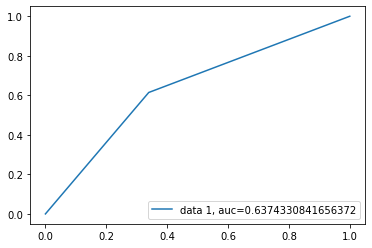

<Figure size 1008x1008 with 0 Axes>

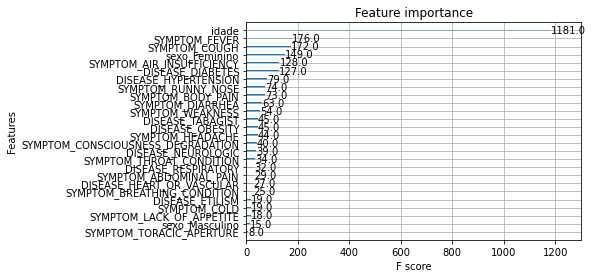

Início do período:  2022-02-15 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8147942728299091
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.6737804878048781
########################################
"""Métricas f1_score:"""
f1:  0.5560165975103735
macro:  0.6490926361045843
micro:  0.6737804878048781
weighted:  0.6888202135533328
########################################
"""Métricas precision_score:"""
Precision:  0.4557823129251701
macro:  0.6533055211034691
micro:  0.6737804878048781
weighted:  0.7376142075210357
########################################
"""Métricas recall_score:"""
Recall:  0.7127659574468085
macro:  0.6854428077832333
micro:  0.6737804878048781
weighted:  0.6737804878048781
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6854428077832333


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


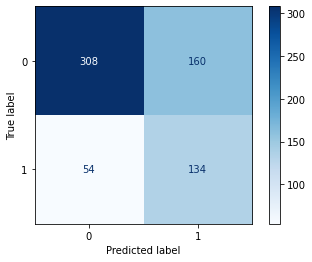

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       468
           1       0.46      0.71      0.56       188

    accuracy                           0.67       656
   macro avg       0.65      0.69      0.65       656
weighted avg       0.74      0.67      0.69       656

roc_auc_score:  0.6854428077832333


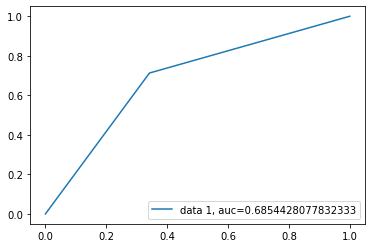

<Figure size 1008x1008 with 0 Axes>

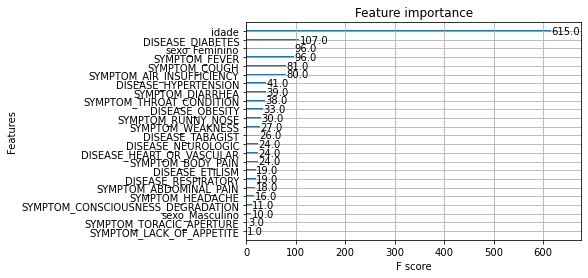

Início do período:  2022-03-17 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8516069095432417
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.702572347266881
########################################
"""Métricas f1_score:"""
f1:  0.33212996389891697
macro:  0.5704083118357046
micro:  0.702572347266881
weighted:  0.7611842238494027
########################################
"""Métricas precision_score:"""
Precision:  0.21395348837209302
macro:  0.5873207245300268
micro:  0.702572347266881
weighted:  0.8862546210037424
########################################
"""Métricas recall_score:"""
Recall:  0.7419354838709677
macro:  0.7200748847926267
micro:  0.702572347266881
weighted:  0.702572347266881
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.7200748847926267


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


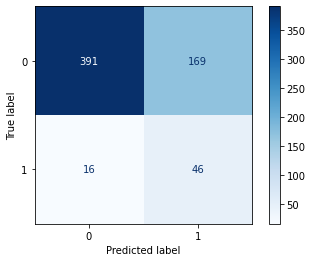

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       560
           1       0.21      0.74      0.33        62

    accuracy                           0.70       622
   macro avg       0.59      0.72      0.57       622
weighted avg       0.89      0.70      0.76       622

roc_auc_score:  0.7200748847926267


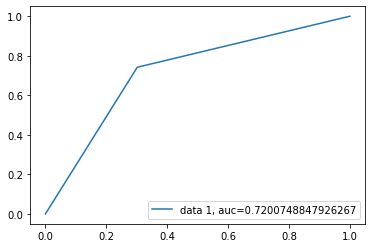

<Figure size 1008x1008 with 0 Axes>

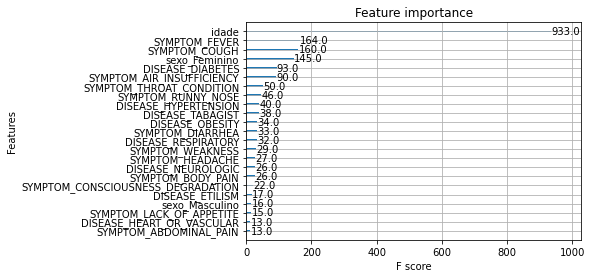

In [9]:
results_accuracy_90_xg, results_f1_90_xg, results_precision_90_xg, results_recall_90_xg, results_roc_auc_90_xg = apply_periodos(90, df)

### Lista com as métricas de cada período:

In [10]:
metricas_accuracy_90_xg = pd.DataFrame(results_accuracy_90_xg)
metricas_accuracy_90_xg.columns = ['accuracy score']
#metricas_accuracy_90_xg
metricas_f1_90_xg = pd.DataFrame(results_f1_90_xg)
metricas_f1_90_xg.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_90_xg
metricas_precision_90_xg = pd.DataFrame(results_precision_90_xg)
metricas_precision_90_xg.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_90_xg
metricas_recall_90_xg = pd.DataFrame(results_recall_90_xg)
metricas_recall_90_xg.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_90_xg
metricas_roc_auc_90_xg = pd.DataFrame(results_roc_auc_90_xg)
metricas_roc_auc_90_xg.columns = ['roc_auc score']
#metricas_roc_auc_90_xg
metricas_90_xg = pd.concat([metricas_accuracy_90_xg, metricas_f1_90_xg, metricas_precision_90_xg, metricas_recall_90_xg, metricas_roc_auc_90_xg], axis=1)
metricas_90_xg


accuracy score  f1 score  f1 score macro  f1 score micro  \
0         0.748095  0.568310        0.695235        0.748095   
1         0.579252  0.528048        0.574240        0.579252   
2         0.567277  0.463740        0.550522        0.567277   
3         0.627874  0.432355        0.577783        0.627874   
4         0.653131  0.424658        0.588191        0.653131   
5         0.665680  0.469484        0.612712        0.665680   
6         0.663303  0.468886        0.611206        0.663303   
7         0.642146  0.519053        0.617061        0.642146   
8         0.629781  0.560065        0.620245        0.629781   
9         0.645094  0.584013        0.637274        0.645094   
10        0.656988  0.576292        0.644078        0.656988   
11        0.656600  0.544144        0.634348        0.656600   
12        0.583960  0.537420        0.579706        0.583960   
13        0.555096  0.508108        0.550999        0.555096   
14        0.581686  0.508557        0.572214        0.581686   
15        0.614437  0.566337        0.609634        0.614437   
16        0.585821  0.524964        0.578910        0.585821   
17        0.569179  0.492715        0.559163        0.569179   
18        0.604871  0.365217        0.539190        0.604871   
19        0.610123  0.344828        0.533660        0.610123   
20        0.626087  0.336892        0.538264        0.626087   
21        0.565486  0.372055        0.519934        0.565486   
22        0.524781  0.417163        0.508007        0.524781   
23        0.643223  0.563380        0.630879        0.643223   
24        0.673780  0.556017        0.649093        0.673780   
25        0.702572  0.332130        0.570408        0.702572   

    f1 score weighted  precision score  precision score macro  \
0            0.748095         0.469112               0.684864   
1            0.579252         0.378657               0.643725   
2            0.567277         0.315648               0.624588   
3            0.627874         0.302909               0.608244   
4            0.653131         0.306425               0.604158   
5            0.665680         0.376884               0.614579   
6            0.663303         0.433155               0.608337   
7            0.642146         0.471028               0.616033   
8            0.629781         0.474553               0.628728   
9            0.645094         0.483784               0.650070   
10           0.656988         0.480243               0.652083   
11           0.656600         0.477848               0.634349   
12           0.583960         0.416153               0.616275   
13           0.555096         0.372561               0.610716   
14           0.581686         0.383057               0.611385   
15           0.614437         0.459069               0.631094   
16           0.585821         0.400871               0.616378   
17           0.569179         0.357006               0.613285   
18           0.604871         0.283784               0.551598   
19           0.610123         0.269784               0.544384   
20           0.626087         0.285714               0.540653   
21           0.565486         0.287688               0.539063   
22           0.524781         0.336538               0.526815   
23           0.643223         0.520231               0.630528   
24           0.673780         0.455782               0.653306   
25           0.702572         0.213953               0.587321   

    precision score micro  precision score weighted  recall score  \
0                0.748095                  0.801340      0.469112   
1                0.579252                  0.765714      0.378657   
2                0.567277                  0.801196      0.315648   
3                0.627874                  0.798954      0.302909   
4                0.653131                  0.791650      0.306425   
5                0.665680                  0.739286      0.376884   
6                0.663303           

In [13]:
list_periodos_90 = [['26/02/2020 até 26/05/2020'], ['27/03/2020 até 25/06/2020'], ['26/04/2020 até 25/07/2020'], ['26/05/2020 até 24/08/2020'], 
['25/06/2020 até 23/09/2020'], ['25/07/2020 até 23/10/2020'], ['24/08/2020 até 22/11/2020'], ['23/09/2020 até 22/12/2020'], ['23/10/2020 até 21/01/2021'], 
['22/11/2020 até 20/02/2021'], ['22/12/2020 até 22/03/2022'], ['21/01/2021 até 21/04/2021'], ['20/02/2021 até 21/05/2021'], ['22/03/2021 até 20/06/2021'], 
['21/04/2021 até 20/07/2021'], ['21/05/2021 até 19/08/2021'], ['20/06/2021 até 18/09/2021'], ['20/07/2021 até 18/10/2021'], ['19/08/2021 até 17/11/2021'], 
['18/09/2021 até 17/12/2021'], ['18/10/2021 até 16/01/2022'], ['17/11/2021 até 15/02/2022'], ['17/12/2021 até 17/03/2022'], ['16/01/2022 até 16/04/2022'], 
['15/02/2022 até 16/05/2022'], ['17/03/2022 até 15/06/2022']]

In [14]:
coluna_periodos90 = pd.DataFrame(list_periodos_90)
coluna_periodos90.columns = ['Períodos']
coluna_periodos90

Períodos
0   26/02/2020 até 26/05/2020
1   27/03/2020 até 25/06/2020
2   26/04/2020 até 25/07/2020
3   26/05/2020 até 24/08/2020
4   25/06/2020 até 23/09/2020
5   25/07/2020 até 23/10/2020
6   24/08/2020 até 22/11/2020
7   23/09/2020 até 22/12/2020
8   23/10/2020 até 21/01/2021
9   22/11/2020 até 20/02/2021
10  22/12/2020 até 22/03/2022
11  21/01/2021 até 21/04/2021
12  20/02/2021 até 21/05/2021
13  22/03/2021 até 20/06/2021
14  21/04/2021 até 20/07/2021
15  21/05/2021 até 19/08/2021
16  20/06/2021 até 18/09/2021
17  20/07/2021 até 18/10/2021
18  19/08/2021 até 17/11/2021
19  18/09/2021 até 17/12/2021
20  18/10/2021 até 16/01/2022
21  17/11/2021 até 15/02/2022
22  17/12/2021 até 17/03/2022
23  16/01/2022 até 16/04/2022
24  15/02/2022 até 16/05/2022
25  17/03/2022 até 15/06/2022

In [15]:
metricas_90_xg_final = pd.concat([coluna_periodos90, metricas_90_xg], axis=1)
metricas_90_xg_final

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 26/05/2020        0.748095  0.568310        0.695235   
1   27/03/2020 até 25/06/2020        0.579252  0.528048        0.574240   
2   26/04/2020 até 25/07/2020        0.567277  0.463740        0.550522   
3   26/05/2020 até 24/08/2020        0.627874  0.432355        0.577783   
4   25/06/2020 até 23/09/2020        0.653131  0.424658        0.588191   
5   25/07/2020 até 23/10/2020        0.665680  0.469484        0.612712   
6   24/08/2020 até 22/11/2020        0.663303  0.468886        0.611206   
7   23/09/2020 até 22/12/2020        0.642146  0.519053        0.617061   
8   23/10/2020 até 21/01/2021        0.629781  0.560065        0.620245   
9   22/11/2020 até 20/02/2021        0.645094  0.584013        0.637274   
10  22/12/2020 até 22/03/2022        0.656988  0.576292        0.644078   
11  21/01/2021 até 21/04/2021        0.656600  0.544144        0.634348   
12  20/02/2021 até 21/05/2021        0.583960  0.537420        0.579706   
13  22/03/2021 até 20/06/2021        0.555096  0.508108        0.550999   
14  21/04/2021 até 20/07/2021        0.581686  0.508557        0.572214   
15  21/05/2021 até 19/08/2021        0.614437  0.566337        0.609634   
16  20/06/2021 até 18/09/2021        0.585821  0.524964        0.578910   
17  20/07/2021 até 18/10/2021        0.569179  0.492715        0.559163   
18  19/08/2021 até 17/11/2021        0.604871  0.365217        0.539190   
19  18/09/2021 até 17/12/2021        0.610123  0.344828        0.533660   
20  18/10/2021 até 16/01/2022        0.626087  0.336892        0.538264   
21  17/11/2021 até 15/02/2022        0.565486  0.372055        0.519934   
22  17/12/2021 até 17/03/2022        0.524781  0.417163        0.508007   
23  16/01/2022 até 16/04/2022        0.643223  0.563380        0.630879   
24  15/02/2022 até 16/05/2022        0.673780  0.556017        0.649093   
25  17/03/2022 até 15/06/2022        0.702572  0.332130        0.570408   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.748095           0.748095         0.469112               0.684864   
1         0.579252           0.579252         0.378657               0.643725   
2         0.567277           0.567277         0.315648               0.624588   
3         0.627874           0.627874         0.302909               0.608244   
4         0.653131           0.653131         0.306425               0.604158   
5         0.665680           0.665680         0.376884               0.614579   
6         0.663303           0.663303         0.433155               0.608337   
7         0.642146           0.642146         0.471028               0.616033   
8         0.629781           0.629781         0.474553               0.628728   
9         0.645094           0.645094         0.483784               0.650070   
10        0.656988           0.656988         0.480243               0.652083   
11        0.656600           0.656600         0.477848               0.634349   
12        0.583960           0.583960         0.416153               0.616275   
13        0.555096           0.555096         0.372561               0.610716   
14        0.581686           0.581686         0.383057               0.611385   
15        0.614437           0.614437         0.459069               0.631094   
16        0.585821           0.585821         0.400871               0.616378   
17        0.569179           0.569179         0.357006               0.613285   
18        0.604871           0.604871         0.283784               0.551598   
19        0.610123           0.610123         0.269784               0.544384   
20        0.626087           0.626087         0.285714               0.540653   
21        0.565486           0.565486         0.287688               0.539063   
22        0.524781           0.524781         0.336538               0.526815   
23        0.643223           0.643223         0.520

### Aplicação do modelo considerando períodos de 120 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9598020690716336
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6724924012158054
########################################
"""Métricas f1_score:"""
f1:  0.572137657180675
macro:  0.653426235237855
micro:  0.6724924012158054
weighted:  0.6917438755023971
########################################
"""Métricas precision_score:"""
Precision:  0.436947182208744
macro:  0.6730305852653266
micro:  0.6724924012158054
weighted:  0.784315087060742
########################################
"""Métricas recall_score:"""
Recall:  0.8284619070436032
macro:  0.722459564298183
micro:  0.6724924012158054
weighted:  0.6724924012158054
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.722459564298183


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


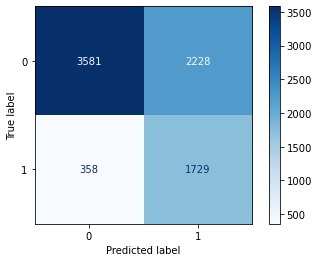

              precision    recall  f1-score   support

           0       0.91      0.62      0.73      5809
           1       0.44      0.83      0.57      2087

    accuracy                           0.67      7896
   macro avg       0.67      0.72      0.65      7896
weighted avg       0.78      0.67      0.69      7896

roc_auc_score:  0.722459564298183


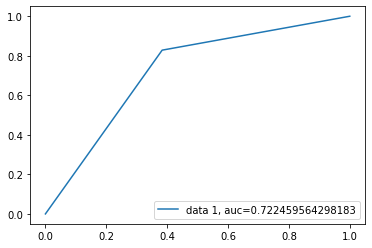

<Figure size 1008x1008 with 0 Axes>

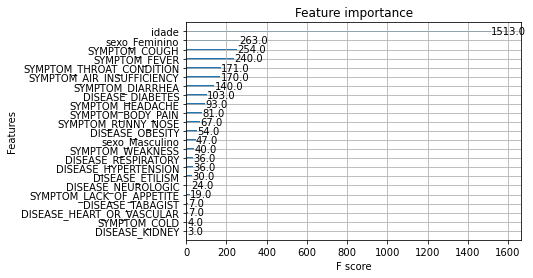

Início do período:  2020-03-27 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.9119397070564077
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5526315789473685
########################################
"""Métricas f1_score:"""
f1:  0.48576512455516
macro:  0.5449373567981279
micro:  0.5526315789473685
weighted:  0.5762027674363112
########################################
"""Métricas precision_score:"""
Precision:  0.33319772172497963
macro:  0.6331009765183431
micro:  0.5526315789473685
weighted:  0.7915637901965702
########################################
"""Métricas recall_score:"""
Recall:  0.8960612691466083
macro:  0.6713594664436621
micro:  0.5526315789473685
weighted:  0.5526315789473685
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6713594664436621


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


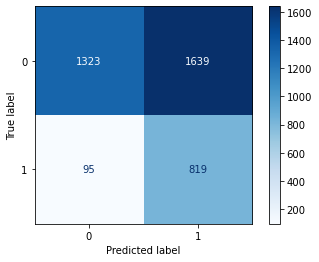

              precision    recall  f1-score   support

           0       0.93      0.45      0.60      2962
           1       0.33      0.90      0.49       914

    accuracy                           0.55      3876
   macro avg       0.63      0.67      0.54      3876
weighted avg       0.79      0.55      0.58      3876

roc_auc_score:  0.6713594664436621


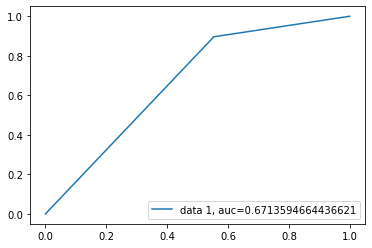

<Figure size 1008x1008 with 0 Axes>

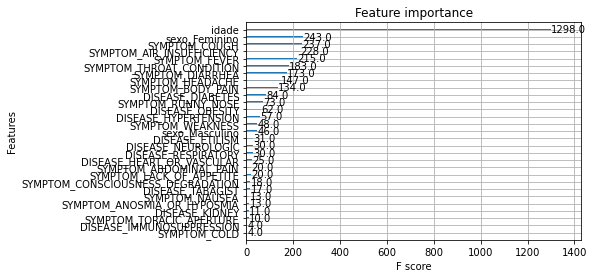

Início do período:  2020-04-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8466352235383321
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5634045485871813
########################################
"""Métricas f1_score:"""
f1:  0.4425868895732512
macro:  0.5418825130392453
micro:  0.5634045485871813
weighted:  0.6025821808644256
########################################
"""Métricas precision_score:"""
Precision:  0.2943241661790521
macro:  0.6215962825865923
micro:  0.5634045485871813
weighted:  0.821658561879141
########################################
"""Métricas recall_score:"""
Recall:  0.8918439716312057
macro:  0.6880092398789048
micro:  0.5634045485871813
weighted:  0.5634045485871813
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6880092398789048


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


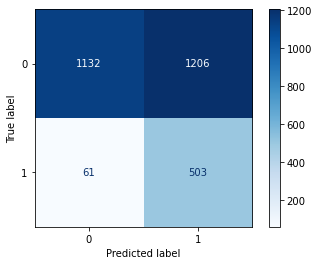

              precision    recall  f1-score   support

           0       0.95      0.48      0.64      2338
           1       0.29      0.89      0.44       564

    accuracy                           0.56      2902
   macro avg       0.62      0.69      0.54      2902
weighted avg       0.82      0.56      0.60      2902

roc_auc_score:  0.6880092398789048


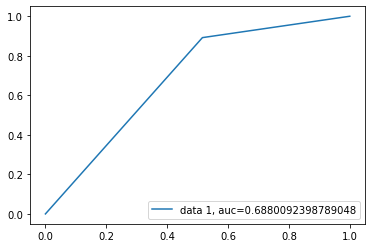

<Figure size 1008x1008 with 0 Axes>

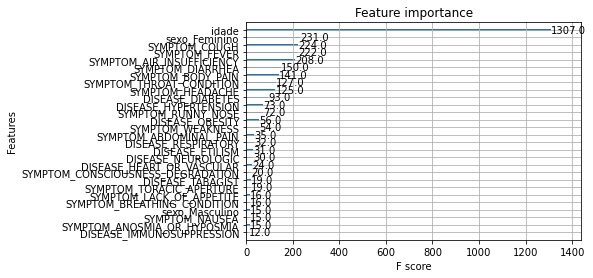

Início do período:  2020-05-26 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.8642513212081525
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.6371268656716418
########################################
"""Métricas f1_score:"""
f1:  0.45897079276773295
macro:  0.592994168313691
micro:  0.6371268656716418
weighted:  0.676383712613275
########################################
"""Métricas precision_score:"""
Precision:  0.3194578896418199
macro:  0.6259755694833762
micro:  0.6371268656716418
weighted:  0.8166913273698669
########################################
"""Métricas recall_score:"""
Recall:  0.8148148148148148
macro:  0.7052797478329393
micro:  0.6371268656716418
weighted:  0.6371268656716418
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.7052797478329393


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


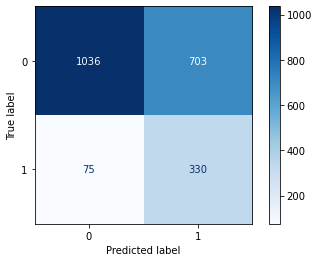

              precision    recall  f1-score   support

           0       0.93      0.60      0.73      1739
           1       0.32      0.81      0.46       405

    accuracy                           0.64      2144
   macro avg       0.63      0.71      0.59      2144
weighted avg       0.82      0.64      0.68      2144

roc_auc_score:  0.7052797478329393


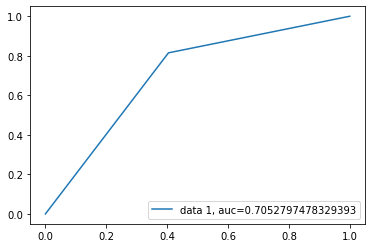

<Figure size 1008x1008 with 0 Axes>

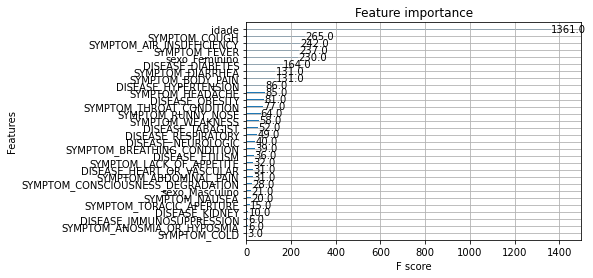

Início do período:  2020-06-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.919484907521614
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6091030789825971
########################################
"""Métricas f1_score:"""
f1:  0.4448669201520913
macro:  0.571607013795054
micro:  0.6091030789825971
weighted:  0.6416788460233586
########################################
"""Métricas precision_score:"""
Precision:  0.32590529247910865
macro:  0.5985196565488327
micro:  0.6091030789825971
weighted:  0.7492421898296842
########################################
"""Métricas recall_score:"""
Recall:  0.7005988023952096
macro:  0.6416787115424324
micro:  0.6091030789825971
weighted:  0.6091030789825971
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6416787115424324


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


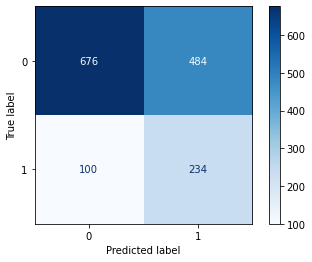

              precision    recall  f1-score   support

           0       0.87      0.58      0.70      1160
           1       0.33      0.70      0.44       334

    accuracy                           0.61      1494
   macro avg       0.60      0.64      0.57      1494
weighted avg       0.75      0.61      0.64      1494

roc_auc_score:  0.6416787115424324


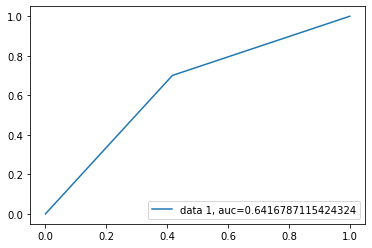

<Figure size 1008x1008 with 0 Axes>

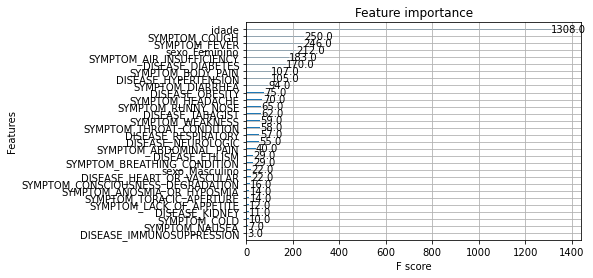

Início do período:  2020-07-25 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9379898954028926
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.64
########################################
"""Métricas f1_score:"""
f1:  0.4759959141981614
macro:  0.6009054931760448
micro:  0.64
weighted:  0.65569039623652
########################################
"""Métricas precision_score:"""
Precision:  0.40241796200345425
macro:  0.6025092174083465
micro:  0.64
weighted:  0.6902685399543519
########################################
"""Métricas recall_score:"""
Recall:  0.5825
macro:  0.622469512195122
micro:  0.64
weighted:  0.64
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6224695121951219


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


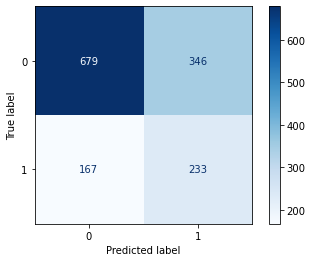

              precision    recall  f1-score   support

           0       0.80      0.66      0.73      1025
           1       0.40      0.58      0.48       400

    accuracy                           0.64      1425
   macro avg       0.60      0.62      0.60      1425
weighted avg       0.69      0.64      0.66      1425

roc_auc_score:  0.6224695121951219


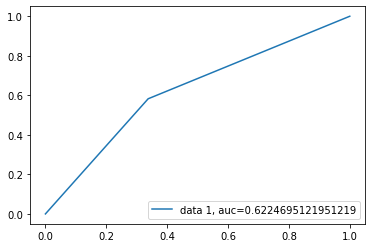

<Figure size 1008x1008 with 0 Axes>

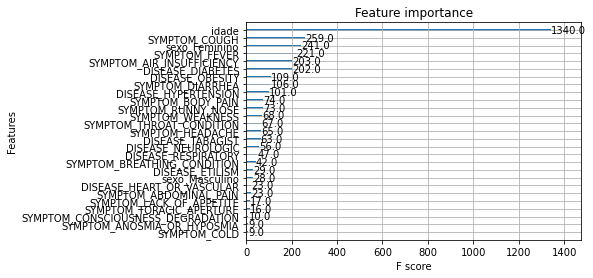

Início do período:  2020-08-24 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9207312336699387
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6375799883653287
########################################
"""Métricas f1_score:"""
f1:  0.4661525278491859
macro:  0.5959120190985252
micro:  0.6375799883653287
weighted:  0.6414297463954137
########################################
"""Métricas precision_score:"""
Precision:  0.4466338259441708
macro:  0.5944880841432565
micro:  0.6375799883653287
weighted:  0.646353190422517
########################################
"""Métricas recall_score:"""
Recall:  0.4874551971326165
macro:  0.5985940929676864
micro:  0.6375799883653287
weighted:  0.6375799883653287
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5985940929676864


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


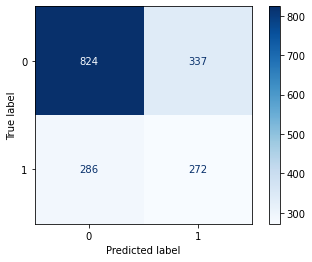

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1161
           1       0.45      0.49      0.47       558

    accuracy                           0.64      1719
   macro avg       0.59      0.60      0.60      1719
weighted avg       0.65      0.64      0.64      1719

roc_auc_score:  0.5985940929676864


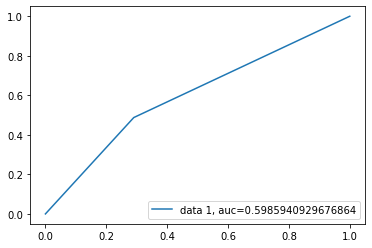

<Figure size 1008x1008 with 0 Axes>

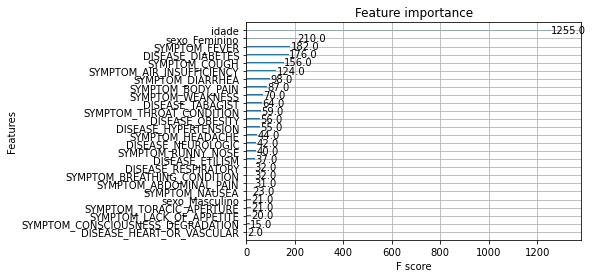

Início do período:  2020-09-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.8931000987316777
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6317747077577046
########################################
"""Métricas f1_score:"""
f1:  0.557188498402556
macro:  0.6210226257360665
micro:  0.6317747077577046
weighted:  0.6408308777885481
########################################
"""Métricas precision_score:"""
Precision:  0.4759825327510917
macro:  0.627742819170577
micro:  0.6317747077577046
weighted:  0.674835277868228
########################################
"""Métricas recall_score:"""
Recall:  0.6718027734976888
macro:  0.6412541848023724
micro:  0.6317747077577046
weighted:  0.6317747077577046
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6412541848023725


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


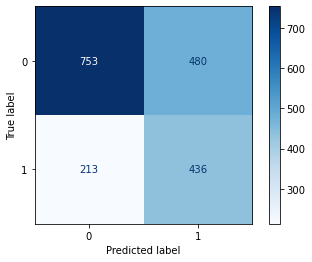

              precision    recall  f1-score   support

           0       0.78      0.61      0.68      1233
           1       0.48      0.67      0.56       649

    accuracy                           0.63      1882
   macro avg       0.63      0.64      0.62      1882
weighted avg       0.67      0.63      0.64      1882

roc_auc_score:  0.6412541848023725


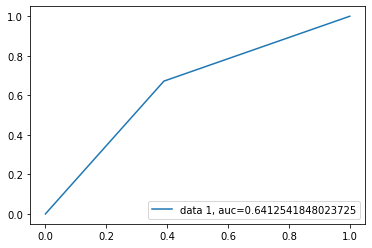

<Figure size 1008x1008 with 0 Axes>

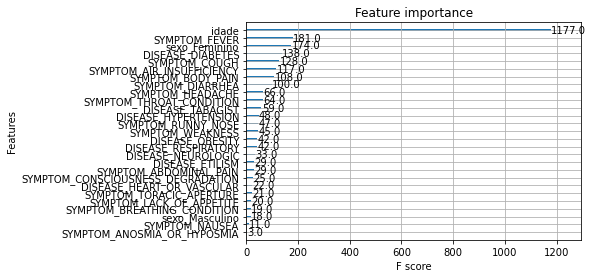

Início do período:  2020-10-23 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8771169470919288
best_params_: {'colsample_bytree': 0.5, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.62254120148857
########################################
"""Métricas f1_score:"""
f1:  0.5748502994011976
macro:  0.617731077042855
micro:  0.62254120148857
weighted:  0.6321614503799997
########################################
"""Métricas precision_score:"""
Precision:  0.4588910133843212
macro:  0.643217961781981
micro:  0.62254120148857
weighted:  0.7052482426622141
########################################
"""Métricas recall_score:"""
Recall:  0.7692307692307693
macro:  0.659476164249434
micro:  0.62254120148857
weighted:  0.62254120148857
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6594761642494339


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


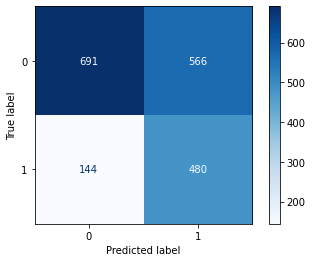

              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1257
           1       0.46      0.77      0.57       624

    accuracy                           0.62      1881
   macro avg       0.64      0.66      0.62      1881
weighted avg       0.71      0.62      0.63      1881

roc_auc_score:  0.6594761642494339


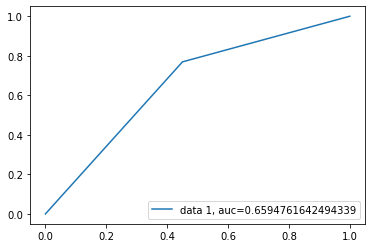

<Figure size 1008x1008 with 0 Axes>

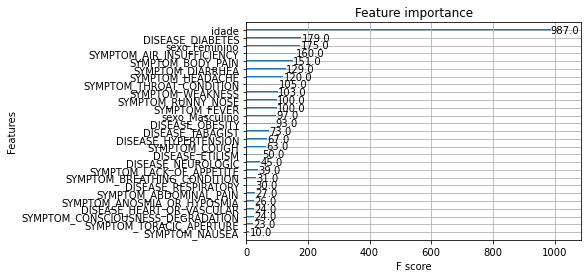

Início do período:  2020-11-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8536168771471428
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.6613226452905812
########################################
"""Métricas f1_score:"""
f1:  0.5743073047858943
macro:  0.6465546507290536
micro:  0.6613226452905812
weighted:  0.6717181551878134
########################################
"""Métricas precision_score:"""
Precision:  0.4863481228668942
macro:  0.6513373267395696
micro:  0.6613226452905812
weighted:  0.7088025043609543
########################################
"""Métricas recall_score:"""
Recall:  0.7011070110701108
macro:  0.671599878900097
micro:  0.6613226452905812
weighted:  0.6613226452905812
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.671599878900097


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


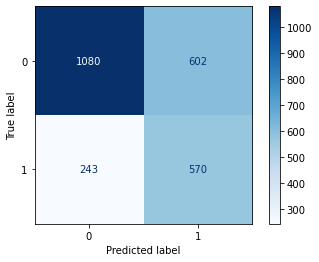

              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1682
           1       0.49      0.70      0.57       813

    accuracy                           0.66      2495
   macro avg       0.65      0.67      0.65      2495
weighted avg       0.71      0.66      0.67      2495

roc_auc_score:  0.671599878900097


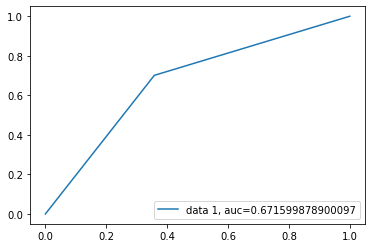

<Figure size 1008x1008 with 0 Axes>

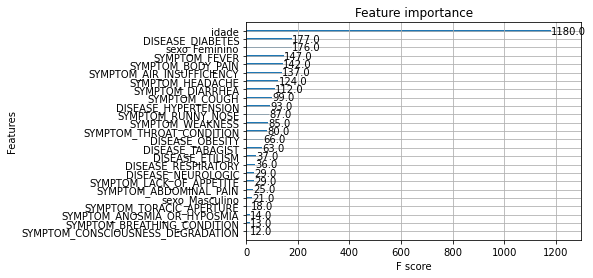

Início do período:  2020-12-22 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8596472192944387
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6306866346425544
########################################
"""Métricas f1_score:"""
f1:  0.5500860585197934
macro:  0.6184410642467167
micro:  0.6306866346425544
weighted:  0.6418312625895549
########################################
"""Métricas precision_score:"""
Precision:  0.45893164847788626
macro:  0.6279641557183647
micro:  0.6306866346425544
weighted:  0.6858048921603594
########################################
"""Métricas recall_score:"""
Recall:  0.686426116838488
macro:  0.6448972689455598
micro:  0.6306866346425544
weighted:  0.6306866346425544
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6448972689455598


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


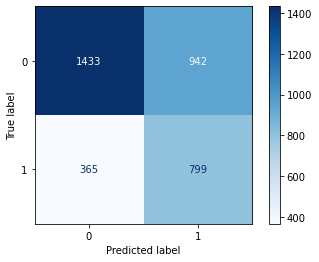

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      2375
           1       0.46      0.69      0.55      1164

    accuracy                           0.63      3539
   macro avg       0.63      0.64      0.62      3539
weighted avg       0.69      0.63      0.64      3539

roc_auc_score:  0.6448972689455598


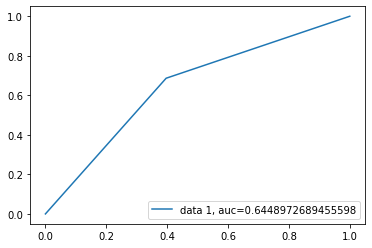

<Figure size 1008x1008 with 0 Axes>

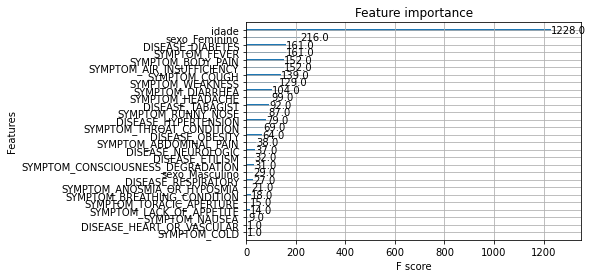

Início do período:  2021-01-21 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8526661962108599
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6312093628088427
########################################
"""Métricas f1_score:"""
f1:  0.5535264483627204
macro:  0.6196963212128179
micro:  0.6312093628088427
weighted:  0.6425675204372079
########################################
"""Métricas precision_score:"""
Precision:  0.45828988529718456
macro:  0.6308055549993966
micro:  0.6312093628088427
weighted:  0.6904345081942576
########################################
"""Métricas recall_score:"""
Recall:  0.6987281399046105
macro:  0.6485523188892979
micro:  0.6312093628088427
weighted:  0.6312093628088427
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.648552318889298


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


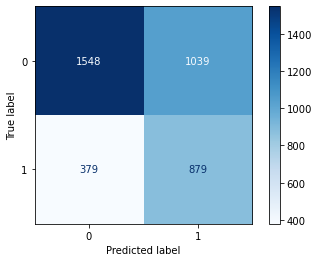

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      2587
           1       0.46      0.70      0.55      1258

    accuracy                           0.63      3845
   macro avg       0.63      0.65      0.62      3845
weighted avg       0.69      0.63      0.64      3845

roc_auc_score:  0.648552318889298


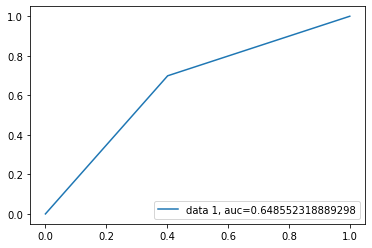

<Figure size 1008x1008 with 0 Axes>

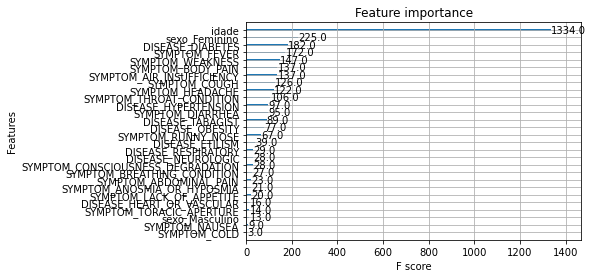

Início do período:  2021-02-20 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8578619857210686
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5709111173028699
########################################
"""Métricas f1_score:"""
f1:  0.5344619105199516
macro:  0.568264546991242
micro:  0.5709111173028699
weighted:  0.5813843777531555
########################################
"""Métricas precision_score:"""
Precision:  0.4
macro:  0.6224075416968817
micro:  0.5709111173028699
weighted:  0.7087306694716816
########################################
"""Métricas recall_score:"""
Recall:  0.8051001821493625
macro:  0.6363919216648057
micro:  0.5709111173028699
weighted:  0.5709111173028699
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6363919216648057


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


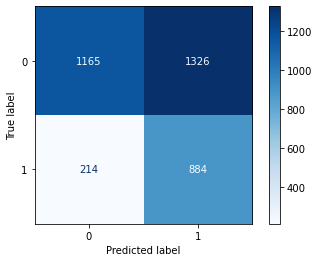

              precision    recall  f1-score   support

           0       0.84      0.47      0.60      2491
           1       0.40      0.81      0.53      1098

    accuracy                           0.57      3589
   macro avg       0.62      0.64      0.57      3589
weighted avg       0.71      0.57      0.58      3589

roc_auc_score:  0.6363919216648057


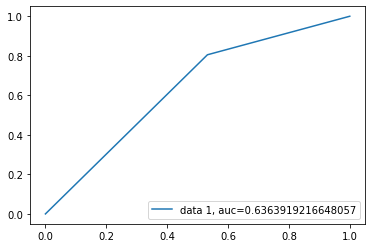

<Figure size 1008x1008 with 0 Axes>

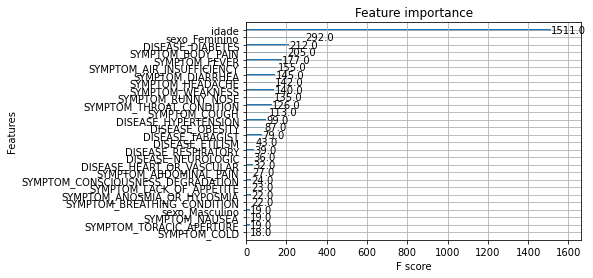

Início do período:  2021-03-22 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8478762705129561
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5566037735849056
########################################
"""Métricas f1_score:"""
f1:  0.5113592606854062
macro:  0.5527694928307108
micro:  0.5566037735849056
weighted:  0.5703059014121605
########################################
"""Métricas precision_score:"""
Precision:  0.3747178329571106
macro:  0.613505705469381
micro:  0.5566037735849056
weighted:  0.7146276137450175
########################################
"""Métricas recall_score:"""
Recall:  0.8048484848484848
macro:  0.6304556611773107
micro:  0.5566037735849056
weighted:  0.5566037735849056
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6304556611773107


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


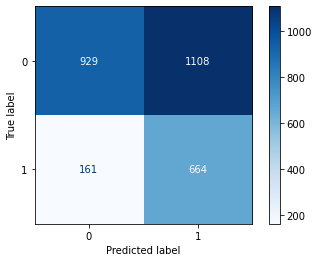

              precision    recall  f1-score   support

           0       0.85      0.46      0.59      2037
           1       0.37      0.80      0.51       825

    accuracy                           0.56      2862
   macro avg       0.61      0.63      0.55      2862
weighted avg       0.71      0.56      0.57      2862

roc_auc_score:  0.6304556611773107


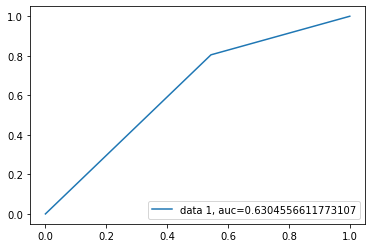

<Figure size 1008x1008 with 0 Axes>

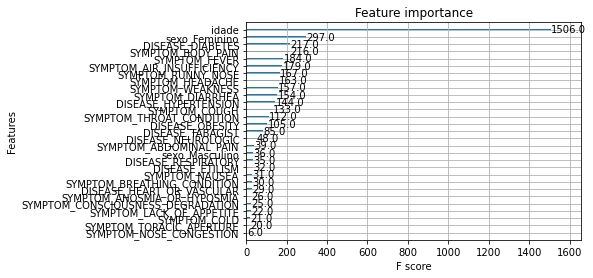

Início do período:  2021-04-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.8701794375157471
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5851979345955249
########################################
"""Métricas f1_score:"""
f1:  0.5438485804416404
macro:  0.5817612181534872
micro:  0.5851979345955249
weighted:  0.5958778572097055
########################################
"""Métricas precision_score:"""
Precision:  0.41522157996146436
macro:  0.6253412864346328
micro:  0.5851979345955249
weighted:  0.7035786298087501
########################################
"""Métricas recall_score:"""
Recall:  0.7879341864716636
macro:  0.6402045514298117
micro:  0.5851979345955249
weighted:  0.5851979345955249
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6402045514298117


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


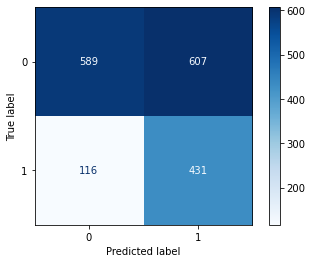

              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1196
           1       0.42      0.79      0.54       547

    accuracy                           0.59      1743
   macro avg       0.63      0.64      0.58      1743
weighted avg       0.70      0.59      0.60      1743

roc_auc_score:  0.6402045514298117


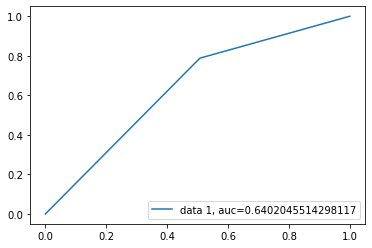

<Figure size 1008x1008 with 0 Axes>

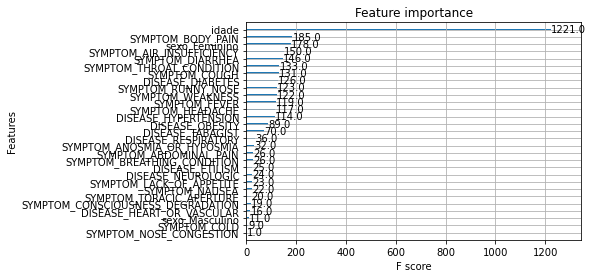

Início do período:  2021-05-21 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8732717291780654
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5719298245614035
########################################
"""Métricas f1_score:"""
f1:  0.5473098330241187
macro:  0.5706599081925918
micro:  0.5719298245614035
weighted:  0.5788938820677902
########################################
"""Métricas precision_score:"""
Precision:  0.41607898448519043
macro:  0.6221926244931753
micro:  0.5719298245614035
weighted:  0.6948748028117804
########################################
"""Métricas recall_score:"""
Recall:  0.7994579945799458
macro:  0.6312465070175994
micro:  0.5719298245614035
weighted:  0.5719298245614035
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6312465070175993


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


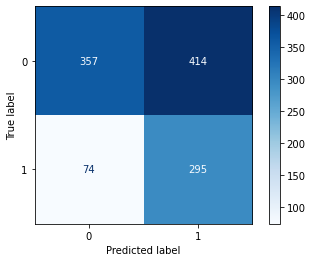

              precision    recall  f1-score   support

           0       0.83      0.46      0.59       771
           1       0.42      0.80      0.55       369

    accuracy                           0.57      1140
   macro avg       0.62      0.63      0.57      1140
weighted avg       0.69      0.57      0.58      1140

roc_auc_score:  0.6312465070175993


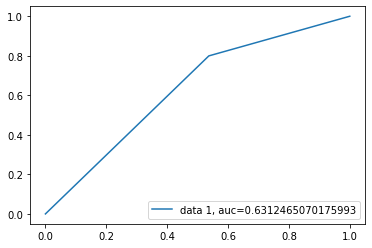

<Figure size 1008x1008 with 0 Axes>

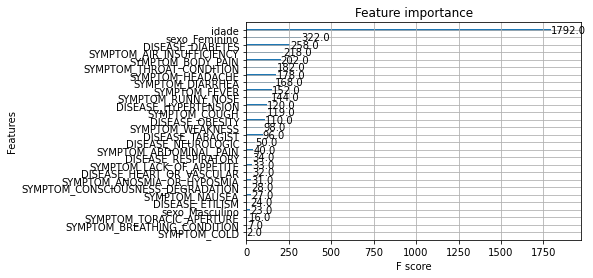

Início do período:  2021-06-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8794290766825299
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5675438596491228
########################################
"""Métricas f1_score:"""
f1:  0.5074925074925074
macro:  0.5610175594538378
micro:  0.5675438596491228
weighted:  0.584869073836606
########################################
"""Métricas precision_score:"""
Precision:  0.3708029197080292
macro:  0.6172695917221465
micro:  0.5675438596491228
weighted:  0.7270985999529987
########################################
"""Métricas recall_score:"""
Recall:  0.8037974683544303
macro:  0.640369607963623
micro:  0.5675438596491228
weighted:  0.5675438596491228
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6403696079636229


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


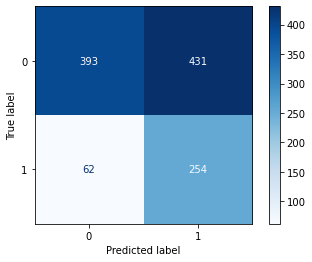

              precision    recall  f1-score   support

           0       0.86      0.48      0.61       824
           1       0.37      0.80      0.51       316

    accuracy                           0.57      1140
   macro avg       0.62      0.64      0.56      1140
weighted avg       0.73      0.57      0.58      1140

roc_auc_score:  0.6403696079636229


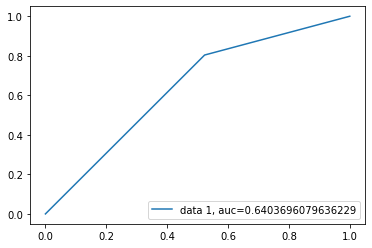

<Figure size 1008x1008 with 0 Axes>

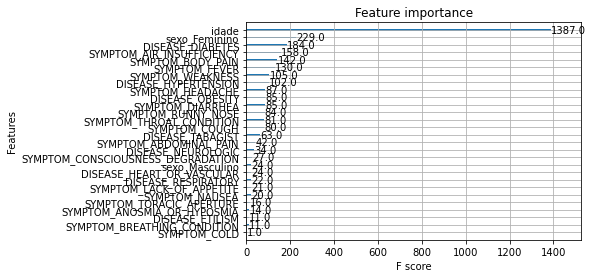

Início do período:  2021-07-20 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.8673254471305032
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5732959850606909
########################################
"""Métricas f1_score:"""
f1:  0.4578884934756821
macro:  0.5530397047824908
micro:  0.5732959850606909
weighted:  0.6030585021361166
########################################
"""Métricas precision_score:"""
Precision:  0.32767402376910015
macro:  0.6005590035857948
micro:  0.5732959850606909
weighted:  0.7440083440496597
########################################
"""Métricas recall_score:"""
Recall:  0.7598425196850394
macro:  0.6375711986430093
micro:  0.5732959850606909
weighted:  0.5732959850606909
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6375711986430093


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


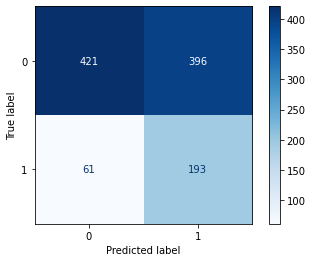

              precision    recall  f1-score   support

           0       0.87      0.52      0.65       817
           1       0.33      0.76      0.46       254

    accuracy                           0.57      1071
   macro avg       0.60      0.64      0.55      1071
weighted avg       0.74      0.57      0.60      1071

roc_auc_score:  0.6375711986430093


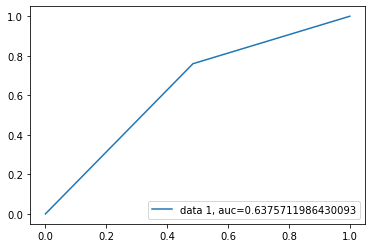

<Figure size 1008x1008 with 0 Axes>

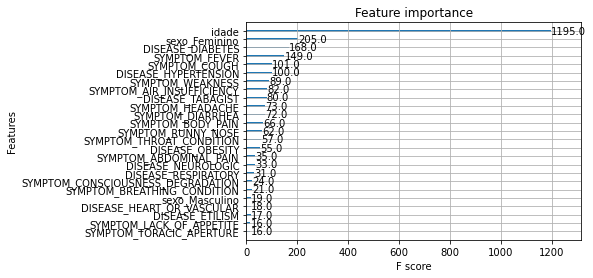

Início do período:  2021-08-19 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.8941173528337844
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5811088295687885
########################################
"""Métricas f1_score:"""
f1:  0.3482428115015974
macro:  0.5198097567341573
micro:  0.5811088295687885
weighted:  0.6180996493827902
########################################
"""Métricas precision_score:"""
Precision:  0.2607655502392344
macro:  0.5413539981411999
micro:  0.5811088295687885
weighted:  0.7021017947831883
########################################
"""Métricas recall_score:"""
Recall:  0.5240384615384616
macro:  0.560322102831894
micro:  0.5811088295687885
weighted:  0.5811088295687885
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.560322102831894


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


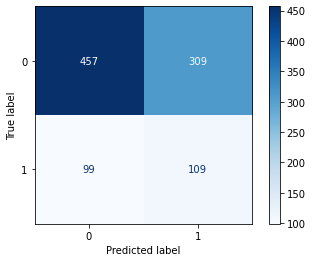

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       766
           1       0.26      0.52      0.35       208

    accuracy                           0.58       974
   macro avg       0.54      0.56      0.52       974
weighted avg       0.70      0.58      0.62       974

roc_auc_score:  0.560322102831894


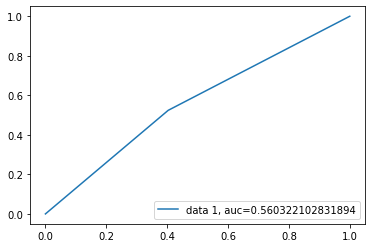

<Figure size 1008x1008 with 0 Axes>

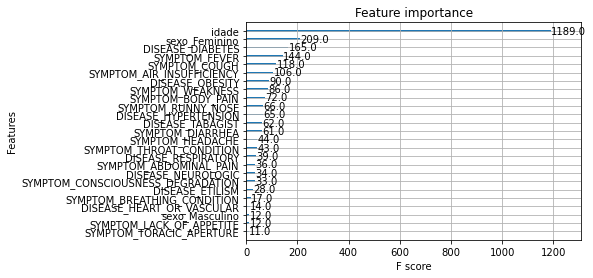

Início do período:  2021-09-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9112100412669963
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5844594594594594
########################################
"""Métricas f1_score:"""
f1:  0.35149384885764495
macro:  0.5228885979996593
micro:  0.5844594594594594
weighted:  0.6166924809760319
########################################
"""Métricas precision_score:"""
Precision:  0.2717391304347826
macro:  0.5387541806020066
micro:  0.5844594594594594
weighted:  0.6848907958962306
########################################
"""Métricas recall_score:"""
Recall:  0.4975124378109453
macro:  0.5537052727628234
micro:  0.5844594594594594
weighted:  0.5844594594594594
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5537052727628234


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


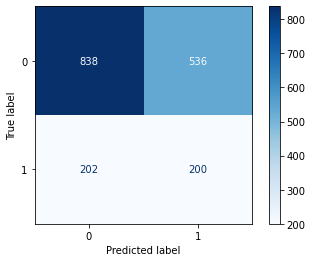

              precision    recall  f1-score   support

           0       0.81      0.61      0.69      1374
           1       0.27      0.50      0.35       402

    accuracy                           0.58      1776
   macro avg       0.54      0.55      0.52      1776
weighted avg       0.68      0.58      0.62      1776

roc_auc_score:  0.5537052727628234


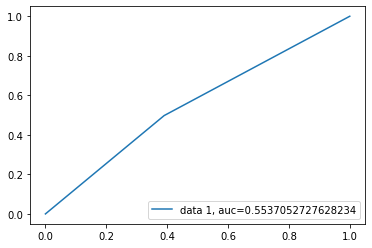

<Figure size 1008x1008 with 0 Axes>

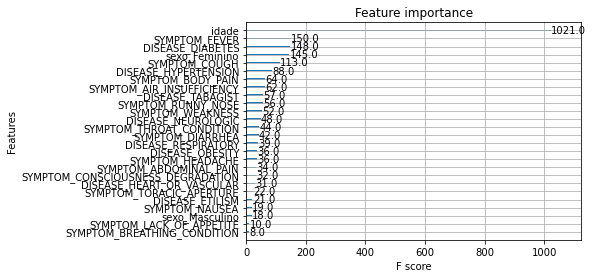

Início do período:  2021-10-18 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.924606830061704
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.611816192560175
########################################
"""Métricas f1_score:"""
f1:  0.3731448763250883
macro:  0.5460019151831463
micro:  0.611816192560175
weighted:  0.6333760420457535
########################################
"""Métricas precision_score:"""
Precision:  0.31058823529411766
macro:  0.550416068866571
micro:  0.611816192560175
weighted:  0.6716419541077893
########################################
"""Métricas recall_score:"""
Recall:  0.4672566371681416
macro:  0.5632794813747685
micro:  0.611816192560175
weighted:  0.611816192560175
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5632794813747685


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


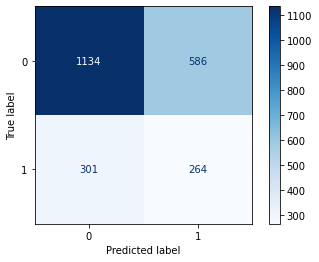

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1720
           1       0.31      0.47      0.37       565

    accuracy                           0.61      2285
   macro avg       0.55      0.56      0.55      2285
weighted avg       0.67      0.61      0.63      2285

roc_auc_score:  0.5632794813747685


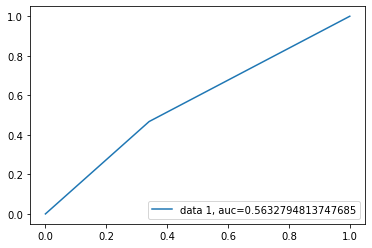

<Figure size 1008x1008 with 0 Axes>

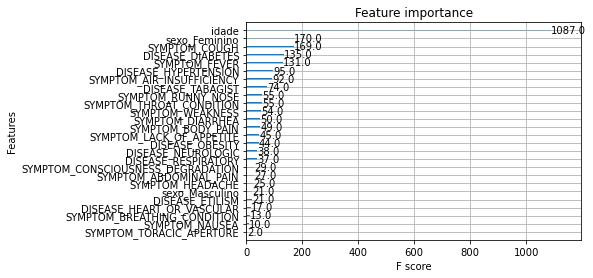

Início do período:  2021-11-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8813690636114071
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.5210628645495787
########################################
"""Métricas f1_score:"""
f1:  0.4176516942474389
macro:  0.5054686649553101
micro:  0.5210628645495787
weighted:  0.5421776384527676
########################################
"""Métricas precision_score:"""
Precision:  0.3231707317073171
macro:  0.5343377863239214
micro:  0.5210628645495787
weighted:  0.6226091733801169
########################################
"""Métricas recall_score:"""
Recall:  0.5902004454342984
macro:  0.5414439155873503
micro:  0.5210628645495787
weighted:  0.5210628645495787
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5414439155873503


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


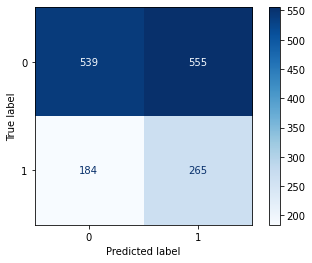

              precision    recall  f1-score   support

           0       0.75      0.49      0.59      1094
           1       0.32      0.59      0.42       449

    accuracy                           0.52      1543
   macro avg       0.53      0.54      0.51      1543
weighted avg       0.62      0.52      0.54      1543

roc_auc_score:  0.5414439155873503


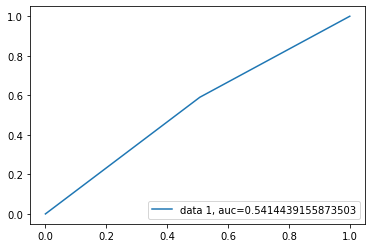

<Figure size 1008x1008 with 0 Axes>

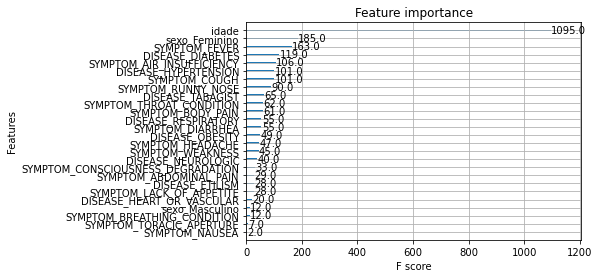

Início do período:  2021-12-17 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8560879229481347
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

"""Accuracy"""
accuracy_score: 0.5828516377649325
########################################
"""Métricas f1_score:"""
f1:  0.5129358830146232
macro:  0.5740753551551634
micro:  0.5828516377649325
weighted:  0.5913923154724261
########################################
"""Métricas precision_score:"""
Precision:  0.4410058027079304
macro:  0.5823071240027176
micro:  0.5828516377649325
weighted:  0.6223288855255186
########################################
"""Métricas recall_score:"""
Recall:  0.6129032258064516
macro:  0.5894846459362588
micro:  0.5828516377649325
weighted:  0.5828516377649325
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5894846459362588


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


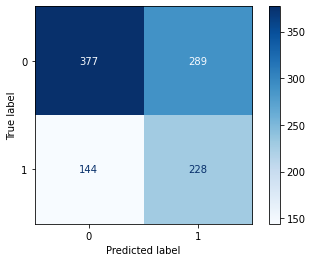

              precision    recall  f1-score   support

           0       0.72      0.57      0.64       666
           1       0.44      0.61      0.51       372

    accuracy                           0.58      1038
   macro avg       0.58      0.59      0.57      1038
weighted avg       0.62      0.58      0.59      1038

roc_auc_score:  0.5894846459362588


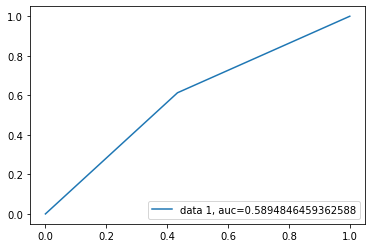

<Figure size 1008x1008 with 0 Axes>

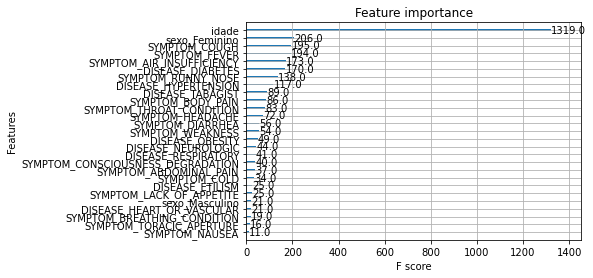

Início do período:  2022-01-16 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.855135405643739
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.6737064413938754
########################################
"""Métricas f1_score:"""
f1:  0.5907284768211921
macro:  0.6597189355133177
micro:  0.6737064413938754
weighted:  0.6826671873486078
########################################
"""Métricas precision_score:"""
Precision:  0.5079726651480638
macro:  0.6624508995031657
micro:  0.6737064413938754
weighted:  0.713834895091188
########################################
"""Métricas recall_score:"""
Recall:  0.7056962025316456
macro:  0.6816912074464884
micro:  0.6737064413938754
weighted:  0.6737064413938754
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.6816912074464884


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


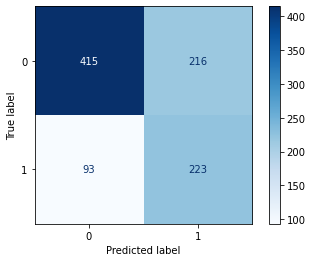

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       631
           1       0.51      0.71      0.59       316

    accuracy                           0.67       947
   macro avg       0.66      0.68      0.66       947
weighted avg       0.71      0.67      0.68       947

roc_auc_score:  0.6816912074464884


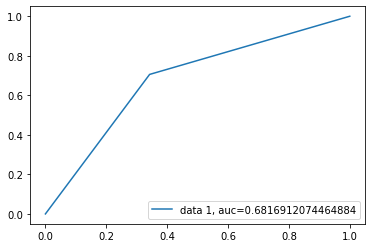

<Figure size 1008x1008 with 0 Axes>

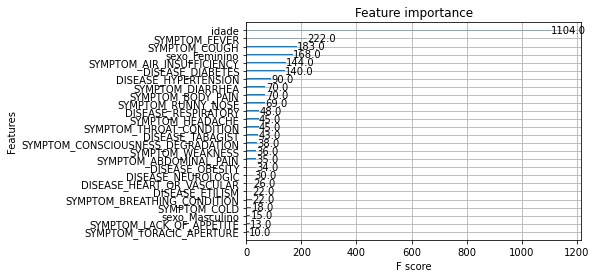

Início do período:  2022-02-15 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8365449195057222
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

"""Accuracy"""
accuracy_score: 0.7137931034482758
########################################
"""Métricas f1_score:"""
f1:  0.4690831556503199
macro:  0.6365872111847194
micro:  0.7137931034482758
weighted:  0.745946180774994
########################################
"""Métricas precision_score:"""
Precision:  0.34591194968553457
macro:  0.635818293683347
micro:  0.7137931034482758
weighted:  0.8250904814888154
########################################
"""Métricas recall_score:"""
Recall:  0.7284768211920529
macro:  0.7195930698449833
micro:  0.7137931034482758
weighted:  0.7137931034482758
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.7195930698449833


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


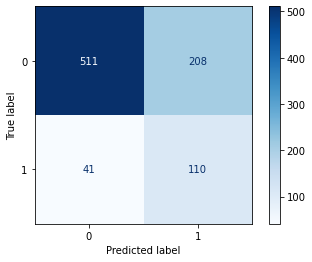

              precision    recall  f1-score   support

           0       0.93      0.71      0.80       719
           1       0.35      0.73      0.47       151

    accuracy                           0.71       870
   macro avg       0.64      0.72      0.64       870
weighted avg       0.83      0.71      0.75       870

roc_auc_score:  0.7195930698449833


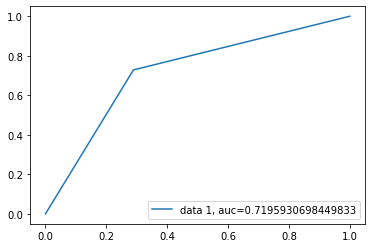

<Figure size 1008x1008 with 0 Axes>

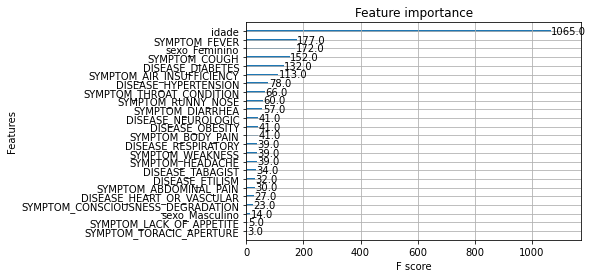

In [11]:
results_accuracy_120_xg, results_f1_120_xg, results_precision_120_xg, results_recall_120_xg, results_roc_auc_120_xg = apply_periodos(120, df)

### Lista com as métricas de cada período:

In [12]:
metricas_accuracy_120_xg = pd.DataFrame(results_accuracy_120_xg)
metricas_accuracy_120_xg.columns = ['accuracy score']
#metricas_accuracy_120_xg
metricas_f1_120_xg = pd.DataFrame(results_f1_120_xg)
metricas_f1_120_xg.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_120_xg
metricas_precision_120_xg = pd.DataFrame(results_precision_120_xg)
metricas_precision_120_xg.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_120_xg
metricas_recall_120_xg = pd.DataFrame(results_recall_120_xg)
metricas_recall_120_xg.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_120_xg
metricas_roc_auc_120_xg = pd.DataFrame(results_roc_auc_120_xg)
metricas_roc_auc_120_xg.columns = ['roc_auc score']
#metricas_roc_auc_120_xg
metricas_120_xg = pd.concat([metricas_accuracy_120_xg, metricas_f1_120_xg, metricas_precision_120_xg, metricas_recall_120_xg, metricas_roc_auc_120_xg], axis=1)
metricas_120_xg

accuracy score  f1 score  f1 score macro  f1 score micro  \
0         0.672492  0.572138        0.653426        0.672492   
1         0.552632  0.485765        0.544937        0.552632   
2         0.563405  0.442587        0.541883        0.563405   
3         0.637127  0.458971        0.592994        0.637127   
4         0.609103  0.444867        0.571607        0.609103   
5         0.640000  0.475996        0.600905        0.640000   
6         0.637580  0.466153        0.595912        0.637580   
7         0.631775  0.557188        0.621023        0.631775   
8         0.622541  0.574850        0.617731        0.622541   
9         0.661323  0.574307        0.646555        0.661323   
10        0.630687  0.550086        0.618441        0.630687   
11        0.631209  0.553526        0.619696        0.631209   
12        0.570911  0.534462        0.568265        0.570911   
13        0.556604  0.511359        0.552769        0.556604   
14        0.585198  0.543849        0.581761        0.585198   
15        0.571930  0.547310        0.570660        0.571930   
16        0.567544  0.507493        0.561018        0.567544   
17        0.573296  0.457888        0.553040        0.573296   
18        0.581109  0.348243        0.519810        0.581109   
19        0.584459  0.351494        0.522889        0.584459   
20        0.611816  0.373145        0.546002        0.611816   
21        0.521063  0.417652        0.505469        0.521063   
22        0.582852  0.512936        0.574075        0.582852   
23        0.673706  0.590728        0.659719        0.673706   
24        0.713793  0.469083        0.636587        0.713793   

    f1 score weighted  precision score  precision score macro  \
0            0.672492         0.436947               0.673031   
1            0.552632         0.333198               0.633101   
2            0.563405         0.294324               0.621596   
3            0.637127         0.319458               0.625976   
4            0.609103         0.325905               0.598520   
5            0.640000         0.402418               0.602509   
6            0.637580         0.446634               0.594488   
7            0.631775         0.475983               0.627743   
8            0.622541         0.458891               0.643218   
9            0.661323         0.486348               0.651337   
10           0.630687         0.458932               0.627964   
11           0.631209         0.458290               0.630806   
12           0.570911         0.400000               0.622408   
13           0.556604         0.374718               0.613506   
14           0.585198         0.415222               0.625341   
15           0.571930         0.416079               0.622193   
16           0.567544         0.370803               0.617270   
17           0.573296         0.327674               0.600559   
18           0.581109         0.260766               0.541354   
19           0.584459         0.271739               0.538754   
20           0.611816         0.310588               0.550416   
21           0.521063         0.323171               0.534338   
22           0.582852         0.441006               0.582307   
23           0.673706         0.507973               0.662451   
24           0.713793         0.345912               0.635818   

    precision score micro  precision score weighted  recall score  \
0                0.672492                  0.784315      0.436947   
1                0.552632                  0.791564      0.333198   
2                0.563405                  0.821659      0.294324   
3                0.637127                  0.816691      0.319458   
4                0.609103                  0.749242      0.325905   
5                0.640000                  0.690269      0.402418   
6                0.637580                  0.646353      0.446634   
7                0.631775                  0.674835      0.475983   
8                0.622541  

In [16]:
list_periodos_120 = [['26/02/2020 até 25/06/2020'], ['27/03/2020 até 25/07/2020'], ['26/04/2020 até 24/08/2020'], ['26/05/2020 até 23/09/2020'], 
['25/06/2020 até 23/10/2020'], ['25/07/2020 até 22/11/2020'], ['24/08/2020 até 22/12/2020'], ['23/09/2020 até 21/01/2021'], ['23/10/2020 até 20/02/2021'], 
['22/11/2020 até 22/03/2021'], ['22/12/2020 até 21/04/2021'], ['21/01/2021 até 21/05/2021'], ['20/02/2021 até 20/06/2021'], ['22/03/2021 até 20/07/2021'], 
['21/04/2021 até 19/08/2021'], ['21/05/2021 até 18/09/2021'], ['20/06/2021 até 18/10/2021'], ['20/07/2021 até 17/11/2021'], ['19/08/2021 até 17/12/2021'], 
['18/09/2021 até 16/01/2022'], ['18/10/2021 até 15/02/2022'], ['17/11/2021 até 17/03/2022'], ['17/12/2021 até 16/04/2022'], ['16/01/2022 até 16/05/2022'], 
['15/02/2022 até 15/06/2022']]

In [17]:
coluna_periodos120 = pd.DataFrame(list_periodos_120)
coluna_periodos120.columns = ['Períodos']
metricas_120_xg_final = pd.concat([coluna_periodos120, metricas_120_xg], axis=1)
metricas_120_xg_final

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 25/06/2020        0.672492  0.572138        0.653426   
1   27/03/2020 até 25/07/2020        0.552632  0.485765        0.544937   
2   26/04/2020 até 24/08/2020        0.563405  0.442587        0.541883   
3   26/05/2020 até 23/09/2020        0.637127  0.458971        0.592994   
4   25/06/2020 até 23/10/2020        0.609103  0.444867        0.571607   
5   25/07/2020 até 22/11/2020        0.640000  0.475996        0.600905   
6   24/08/2020 até 22/12/2020        0.637580  0.466153        0.595912   
7   23/09/2020 até 21/01/2021        0.631775  0.557188        0.621023   
8   23/10/2020 até 20/02/2021        0.622541  0.574850        0.617731   
9   22/11/2020 até 22/03/2021        0.661323  0.574307        0.646555   
10  22/12/2020 até 21/04/2021        0.630687  0.550086        0.618441   
11  21/01/2021 até 21/05/2021        0.631209  0.553526        0.619696   
12  20/02/2021 até 20/06/2021        0.570911  0.534462        0.568265   
13  22/03/2021 até 20/07/2021        0.556604  0.511359        0.552769   
14  21/04/2021 até 19/08/2021        0.585198  0.543849        0.581761   
15  21/05/2021 até 18/09/2021        0.571930  0.547310        0.570660   
16  20/06/2021 até 18/10/2021        0.567544  0.507493        0.561018   
17  20/07/2021 até 17/11/2021        0.573296  0.457888        0.553040   
18  19/08/2021 até 17/12/2021        0.581109  0.348243        0.519810   
19  18/09/2021 até 16/01/2022        0.584459  0.351494        0.522889   
20  18/10/2021 até 15/02/2022        0.611816  0.373145        0.546002   
21  17/11/2021 até 17/03/2022        0.521063  0.417652        0.505469   
22  17/12/2021 até 16/04/2022        0.582852  0.512936        0.574075   
23  16/01/2022 até 16/05/2022        0.673706  0.590728        0.659719   
24  15/02/2022 até 15/06/2022        0.713793  0.469083        0.636587   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.672492           0.672492         0.436947               0.673031   
1         0.552632           0.552632         0.333198               0.633101   
2         0.563405           0.563405         0.294324               0.621596   
3         0.637127           0.637127         0.319458               0.625976   
4         0.609103           0.609103         0.325905               0.598520   
5         0.640000           0.640000         0.402418               0.602509   
6         0.637580           0.637580         0.446634               0.594488   
7         0.631775           0.631775         0.475983               0.627743   
8         0.622541           0.622541         0.458891               0.643218   
9         0.661323           0.661323         0.486348               0.651337   
10        0.630687           0.630687         0.458932               0.627964   
11        0.631209           0.631209         0.458290               0.630806   
12        0.570911           0.570911         0.400000               0.622408   
13        0.556604           0.556604         0.374718               0.613506   
14        0.585198           0.585198         0.415222               0.625341   
15        0.571930           0.571930         0.416079               0.622193   
16        0.567544           0.567544         0.370803               0.617270   
17        0.573296           0.573296         0.327674               0.600559   
18        0.581109           0.581109         0.260766               0.541354   
19        0.584459           0.584459         0.271739               0.538754   
20        0.611816           0.611816         0.310588               0.550416   
21        0.521063           0.521063         0.323171               0.534338   
22        0.582852           0.582852         0.441006               0.582307   
23        0.673706           0.673706         0.507973               0.662451   
24        0.713793           0.713793        

In [18]:
metricas_90_xg_final

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 26/05/2020        0.748095  0.568310        0.695235   
1   27/03/2020 até 25/06/2020        0.579252  0.528048        0.574240   
2   26/04/2020 até 25/07/2020        0.567277  0.463740        0.550522   
3   26/05/2020 até 24/08/2020        0.627874  0.432355        0.577783   
4   25/06/2020 até 23/09/2020        0.653131  0.424658        0.588191   
5   25/07/2020 até 23/10/2020        0.665680  0.469484        0.612712   
6   24/08/2020 até 22/11/2020        0.663303  0.468886        0.611206   
7   23/09/2020 até 22/12/2020        0.642146  0.519053        0.617061   
8   23/10/2020 até 21/01/2021        0.629781  0.560065        0.620245   
9   22/11/2020 até 20/02/2021        0.645094  0.584013        0.637274   
10  22/12/2020 até 22/03/2022        0.656988  0.576292        0.644078   
11  21/01/2021 até 21/04/2021        0.656600  0.544144        0.634348   
12  20/02/2021 até 21/05/2021        0.583960  0.537420        0.579706   
13  22/03/2021 até 20/06/2021        0.555096  0.508108        0.550999   
14  21/04/2021 até 20/07/2021        0.581686  0.508557        0.572214   
15  21/05/2021 até 19/08/2021        0.614437  0.566337        0.609634   
16  20/06/2021 até 18/09/2021        0.585821  0.524964        0.578910   
17  20/07/2021 até 18/10/2021        0.569179  0.492715        0.559163   
18  19/08/2021 até 17/11/2021        0.604871  0.365217        0.539190   
19  18/09/2021 até 17/12/2021        0.610123  0.344828        0.533660   
20  18/10/2021 até 16/01/2022        0.626087  0.336892        0.538264   
21  17/11/2021 até 15/02/2022        0.565486  0.372055        0.519934   
22  17/12/2021 até 17/03/2022        0.524781  0.417163        0.508007   
23  16/01/2022 até 16/04/2022        0.643223  0.563380        0.630879   
24  15/02/2022 até 16/05/2022        0.673780  0.556017        0.649093   
25  17/03/2022 até 15/06/2022        0.702572  0.332130        0.570408   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.748095           0.748095         0.469112               0.684864   
1         0.579252           0.579252         0.378657               0.643725   
2         0.567277           0.567277         0.315648               0.624588   
3         0.627874           0.627874         0.302909               0.608244   
4         0.653131           0.653131         0.306425               0.604158   
5         0.665680           0.665680         0.376884               0.614579   
6         0.663303           0.663303         0.433155               0.608337   
7         0.642146           0.642146         0.471028               0.616033   
8         0.629781           0.629781         0.474553               0.628728   
9         0.645094           0.645094         0.483784               0.650070   
10        0.656988           0.656988         0.480243               0.652083   
11        0.656600           0.656600         0.477848               0.634349   
12        0.583960           0.583960         0.416153               0.616275   
13        0.555096           0.555096         0.372561               0.610716   
14        0.581686           0.581686         0.383057               0.611385   
15        0.614437           0.614437         0.459069               0.631094   
16        0.585821           0.585821         0.400871               0.616378   
17        0.569179           0.569179         0.357006               0.613285   
18        0.604871           0.604871         0.283784               0.551598   
19        0.610123           0.610123         0.269784               0.544384   
20        0.626087           0.626087         0.285714               0.540653   
21        0.565486           0.565486         0.287688               0.539063   
22        0.524781           0.524781         0.336538               0.526815   
23        0.643223           0.643223         0.520

In [22]:
metricas_90_xg_final.sort_values(by=['f1 score macro', 'roc_auc score'], ascending=False)

Períodos  accuracy score  f1 score  f1 score macro  \
0   26/02/2020 até 26/05/2020        0.748095  0.568310        0.695235   
24  15/02/2022 até 16/05/2022        0.673780  0.556017        0.649093   
10  22/12/2020 até 22/03/2022        0.656988  0.576292        0.644078   
9   22/11/2020 até 20/02/2021        0.645094  0.584013        0.637274   
11  21/01/2021 até 21/04/2021        0.656600  0.544144        0.634348   
23  16/01/2022 até 16/04/2022        0.643223  0.563380        0.630879   
8   23/10/2020 até 21/01/2021        0.629781  0.560065        0.620245   
7   23/09/2020 até 22/12/2020        0.642146  0.519053        0.617061   
5   25/07/2020 até 23/10/2020        0.665680  0.469484        0.612712   
6   24/08/2020 até 22/11/2020        0.663303  0.468886        0.611206   
15  21/05/2021 até 19/08/2021        0.614437  0.566337        0.609634   
4   25/06/2020 até 23/09/2020        0.653131  0.424658        0.588191   
12  20/02/2021 até 21/05/2021        0.583960  0.537420        0.579706   
16  20/06/2021 até 18/09/2021        0.585821  0.524964        0.578910   
3   26/05/2020 até 24/08/2020        0.627874  0.432355        0.577783   
1   27/03/2020 até 25/06/2020        0.579252  0.528048        0.574240   
14  21/04/2021 até 20/07/2021        0.581686  0.508557        0.572214   
25  17/03/2022 até 15/06/2022        0.702572  0.332130        0.570408   
17  20/07/2021 até 18/10/2021        0.569179  0.492715        0.559163   
13  22/03/2021 até 20/06/2021        0.555096  0.508108        0.550999   
2   26/04/2020 até 25/07/2020        0.567277  0.463740        0.550522   
18  19/08/2021 até 17/11/2021        0.604871  0.365217        0.539190   
20  18/10/2021 até 16/01/2022        0.626087  0.336892        0.538264   
19  18/09/2021 até 17/12/2021        0.610123  0.344828        0.533660   
21  17/11/2021 até 15/02/2022        0.565486  0.372055        0.519934   
22  17/12/2021 até 17/03/2022        0.524781  0.417163        0.508007   

    f1 score micro  f1 score weighted  precision score  precision score macro  \
0         0.748095           0.748095         0.469112               0.684864   
24        0.673780           0.673780         0.455782               0.653306   
10        0.656988           0.656988         0.480243               0.652083   
9         0.645094           0.645094         0.483784               0.650070   
11        0.656600           0.656600         0.477848               0.634349   
23        0.643223           0.643223         0.520231               0.630528   
8         0.629781           0.629781         0.474553               0.628728   
7         0.642146           0.642146         0.471028               0.616033   
5         0.665680           0.665680         0.376884               0.614579   
6         0.663303           0.663303         0.433155               0.608337   
15        0.614437           0.614437         0.459069               0.631094   
4         0.653131           0.653131         0.306425               0.604158   
12        0.583960           0.583960         0.416153               0.616275   
16        0.585821           0.585821         0.400871               0.616378   
3         0.627874           0.627874         0.302909               0.608244   
1         0.579252           0.579252         0.378657               0.643725   
14        0.581686           0.581686         0.383057               0.611385   
25        0.702572           0.702572         0.213953               0.587321   
17        0.569179           0.569179         0.357006               0.613285   
13        0.555096           0.555096         0.372561               0.610716   
2         0.567277           0.567277         0.315648               0.624588   
18        0.604871           0.604871         0.283784               0.551598   
20        0.626087           0.626087         0.285714               0.540653   
19        0.610123           0.610123         0.269